# PokerStars — Machine Learning (régression stake-by-stake)

**Objectif :** prédire le changement de comportement après une “grosse perte” via 2 cibles continues :
- `diff_fold_share_w`
- `diff_median_size_bb`

**Contraintes du rendu :** uniquement **3 modèles** (pas de Random Forest) :
- Ridge Regression (régression Ridge)
- k-Nearest Neighbors (kNN)
- AdaBoost (AdaBoost) — Boosting (boosting)

**Évaluation :** GroupKFold (5 folds, group = `player_id`) + Mean Squared Error (MSE), Mean Absolute Error (MAE), R-squared (R²), comparé à une baseline.


In [1]:
# =========================
# BLOCK 1 — Setup Colab + Google Drive + locate ml_events export
# =========================

from google.colab import drive
drive.mount("/content/drive")

import os
from pathlib import Path

# (Optional) quick sanity: where are we?
print("Current working dir:", os.getcwd())
print("Drive mounted at: /content/drive")
print("Listing /content/drive/MyDrive (top-level):")
print(sorted([p.name for p in Path("/content/drive/MyDrive").iterdir()])[:50], "...\n")

# Search for exports produced by the EDA notebook
search_roots = [
    Path("/content/drive/MyDrive"),
    # Add other roots here if needed, e.g. shared drives (you can extend later)
]

patterns = [
    "**/ml_events.csv",
    "**/ml_events.parquet",
    "**/_exports/ml_events.csv",
    "**/_exports/ml_events.parquet",
]

found = []
for root in search_roots:
    if not root.exists():
        continue
    for pat in patterns:
        found.extend(list(root.glob(pat)))

# Deduplicate while preserving order
seen = set()
found_unique = []
for p in found:
    ps = str(p)
    if ps not in seen:
        seen.add(ps)
        found_unique.append(ps)

print("=== Found candidate ml_events files ===")
if found_unique:
    for i, ps in enumerate(found_unique, 1):
        print(f"{i:02d}. {ps}")
else:
    print("No ml_events.* found under /content/drive/MyDrive.")
    print("If you stored it elsewhere, tell me the folder name (or we’ll extend search paths).")


Mounted at /content/drive
Current working dir: /content
Drive mounted at: /content/drive
Listing /content/drive/MyDrive (top-level):
['Colab Notebooks', 'Untitled', 'Untitled (1)', 'pokerstars_clean', 'projet adv data'] ...

=== Found candidate ml_events files ===
01. /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.csv
02. /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet


In [2]:
# =========================
# BLOCK 1b — Robust search for ml_events in likely project folders
# =========================

import os
from pathlib import Path

roots = [
    Path("/content/drive/MyDrive/pokerstars_clean"),
    Path("/content/drive/MyDrive/projet adv data"),
]

def find_candidates(root: Path):
    candidates = []
    if not root.exists():
        return candidates

    for dirpath, dirnames, filenames in os.walk(root):
        # speed: skip hidden/system dirs
        dirnames[:] = [d for d in dirnames if not d.startswith(".") and d not in ("__pycache__",)]
        for fn in filenames:
            low = fn.lower()
            if "ml_events" in low and (low.endswith(".csv") or low.endswith(".parquet")):
                candidates.append(str(Path(dirpath) / fn))
            # also catch exports folder even if file name differs slightly
            if ("_exports" in Path(dirpath).parts) and (low.endswith(".csv") or low.endswith(".parquet")) and ("events" in low):
                # keep it as a secondary hint
                candidates.append(str(Path(dirpath) / fn))
    # deduplicate preserving order
    seen = set()
    out = []
    for p in candidates:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

all_found = []
for r in roots:
    print(f"\nSearching in: {r}")
    found = find_candidates(r)
    if found:
        print(f"  -> Found {len(found)} candidate file(s). Showing up to 50:")
        for i, p in enumerate(found[:50], 1):
            print(f"     {i:02d}. {p}")
        all_found.extend(found)
    else:
        print("  -> No candidates found in this folder.")

print("\n=== SUMMARY ===")
if all_found:
    print(f"Total candidates found: {len(all_found)}")
else:
    print("No ml_events.* found in the searched roots.")
    print("If you exported elsewhere, tell me the folder name and I’ll add it to the search.")



Searching in: /content/drive/MyDrive/pokerstars_clean
  -> Found 2 candidate file(s). Showing up to 50:
     01. /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.csv
     02. /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

Searching in: /content/drive/MyDrive/projet adv data
  -> No candidates found in this folder.

=== SUMMARY ===
Total candidates found: 2


In [3]:
# =========================
# BLOCK 2 — Load ml_events + quick audit for ML (stake-by-stake)
# =========================

import pandas as pd
import numpy as np
from pathlib import Path

CSV_PATH = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.csv")
PARQUET_PATH = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet")

# 1) Load (prefer parquet)
if PARQUET_PATH.exists():
    print("Loading parquet:", PARQUET_PATH)
    try:
        ml_events = pd.read_parquet(PARQUET_PATH)
    except Exception as e:
        print("Parquet load failed:", repr(e))
        print("Falling back to CSV:", CSV_PATH)
        ml_events = pd.read_csv(CSV_PATH)
elif CSV_PATH.exists():
    print("Loading csv:", CSV_PATH)
    ml_events = pd.read_csv(CSV_PATH)
else:
    raise FileNotFoundError("Neither ml_events.parquet nor ml_events.csv found at expected paths.")

print("\n=== Basic info ===")
print("Shape:", ml_events.shape)
print("Columns (sorted):")
print(sorted(list(ml_events.columns)))

# 2) Check key columns
candidate_keys = [
    ("stake_label", "player_id", "event_hand_id"),
    ("stake_label", "player_id", "hand_id"),  # fallback if naming differs
]
print("\n=== Key columns check ===")
for keys in candidate_keys:
    missing = [k for k in keys if k not in ml_events.columns]
    if not missing:
        print("Found key set:", keys)
        dup = ml_events.duplicated(list(keys)).sum()
        print("  Duplicates on keys:", int(dup))
        break
else:
    print("No full key set found among candidates:", candidate_keys)

# 3) Targets we want
targets = ["diff_fold_share_w", "diff_median_size_bb"]
print("\n=== Target columns availability ===")
for t in targets:
    print(f"{t}: {'OK' if t in ml_events.columns else 'MISSING'}")

# 4) Missingness + simple distribution per stake for targets
print("\n=== Target coverage by stake ===")
if "stake_label" in ml_events.columns:
    for t in targets:
        if t in ml_events.columns:
            tmp = ml_events[["stake_label", t]].copy()
            cov = tmp.groupby("stake_label")[t].apply(lambda s: s.notna().sum()).rename("n_non_null")
            tot = tmp.groupby("stake_label")[t].size().rename("n_total")
            out = pd.concat([tot, cov], axis=1)
            out["pct_non_null"] = (out["n_non_null"] / out["n_total"] * 100).round(1)
            print(f"\n-> {t}")
            print(out)
else:
    print("stake_label not found, cannot show stake-by-stake coverage.")

# 5) Candidate feature columns (PRE-only + event meta if present)
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
meta_cols = [c for c in ["event_len", "event_start_bb", "event_sum_bb", "event_sum_pct_wrt_start1",
                         "start_bb", "net_bb", "net_pct"] if c in ml_events.columns]
count_cols = [c for c in ["n_hands_pre", "n_hands_post", "n_decisions_pre", "n_decisions_post"] if c in ml_events.columns]

print("\n=== Candidate PRE features available ===")
print("Number of pre_* columns:", len(pre_cols))
print("First 30 pre_* columns:", pre_cols[:30])

print("\n=== Candidate meta columns available (event/context) ===")
print(meta_cols)

print("\n=== Coverage / count columns available ===")
print(count_cols)

# 6) Quick sanity on numeric dtypes for targets
print("\n=== Target dtypes + basic stats ===")
for t in targets:
    if t in ml_events.columns:
        s = ml_events[t]
        print(f"\n{t} dtype:", s.dtype)
        print("  non-null:", int(s.notna().sum()))
        print("  mean:", float(s.mean(skipna=True)))
        print("  std:", float(s.std(skipna=True)))
        print("  min/max:", float(s.min(skipna=True)), "/", float(s.max(skipna=True)))


Loading parquet: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

=== Basic info ===
Shape: (1056, 26)
Columns (sorted):
['diff_brs_nf_w', 'diff_brs_w', 'diff_fold_share_w', 'diff_mean_size_bb', 'diff_median_size_bb', 'event_hand_id', 'n_decisions_post', 'n_decisions_pre', 'n_hands_post', 'n_hands_pre', 'player_id', 'post_brs_nf_w', 'post_brs_w', 'post_fold_share_w', 'post_mean_size_bb', 'post_median_size_bb', 'post_n_bets_mean', 'post_n_bets_median', 'pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'stake_label']

=== Key columns check ===
Found key set: ('stake_label', 'player_id', 'event_hand_id')
  Duplicates on keys: 0

=== Target columns availability ===
diff_fold_share_w: OK
diff_median_size_bb: OK

=== Target coverage by stake ===

-> diff_fold_share_w
             n_total  n_non_null  pct_non_null
stake_label                  

In [4]:
# =========================
# BLOCK 3 — Stake-by-stake regression with GroupKFold (2 targets × 3 models)
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# --- 0) Safety checks ---
required_cols = ["stake_label", "player_id", "event_hand_id", "n_hands_pre", "n_decisions_pre"]
for c in required_cols:
    if c not in ml_events.columns:
        raise ValueError(f"Missing required column: {c}")

# --- 1) Define features (anti-leakage: PRE only + PRE coverage) ---
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
feature_cols = pre_cols + ["n_hands_pre", "n_decisions_pre"]

print("Using features:", feature_cols)

# --- 2) Define targets ---
targets = {
    "diff_fold_share_w": "diff_fold_share_w",
    "diff_median_size_bb": "diff_median_size_bb",
}

# --- 3) Define 3 regression models (submission constraint: 3 models) ---
models = {
    "Ridge Regression (régression Ridge)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0, random_state=42)),
    ]),
    "k-Nearest Neighbors (kNN) (k plus proches voisins)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=15)),
    ]),
    "AdaBoost (AdaBoost) — Boosting (boosting)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=2, min_samples_leaf=5, random_state=42),
            n_estimators=400,
            learning_rate=0.05,
            random_state=42,
            loss="linear"
        )),
    ]),
}

# --- 4) CV scoring (regression metrics) ---
scoring = {
    "neg_mse": "neg_mean_squared_error",         # will flip sign later
    "neg_mae": "neg_mean_absolute_error",        # will flip sign later
    "r2": "r2"
}

rows = []

# --- 5) Stake-by-stake loop ---
stakes = sorted(ml_events["stake_label"].unique())
print("\nStakes found:", stakes)

for stake in stakes:
    df_s = ml_events[ml_events["stake_label"] == stake].copy()

    # group split by player_id to avoid leakage
    groups_all = df_s["player_id"].values
    n_players = df_s["player_id"].nunique()

    # choose splits safely
    n_splits = min(5, n_players)
    if n_splits < 2:
        print(f"\n[Stake {stake}] Not enough players for GroupKFold (n_players={n_players}). Skipping.")
        continue

    gkf = GroupKFold(n_splits=n_splits)

    for target_name, target_col in targets.items():
        # filter missing target rows
        df_t = df_s[df_s[target_col].notna()].copy()

        n_events = len(df_t)
        n_players_t = df_t["player_id"].nunique()

        # need enough groups in this filtered dataset too
        n_splits_t = min(n_splits, n_players_t)
        if n_splits_t < 2:
            print(f"[Stake {stake} | {target_name}] Not enough players after filtering (n_players={n_players_t}). Skipping.")
            continue

        gkf_t = GroupKFold(n_splits=n_splits_t)

        X = df_t[feature_cols]
        y = df_t[target_col].astype(float).values
        groups = df_t["player_id"].values

        for model_name, pipe in models.items():
            cvres = cross_validate(
                pipe, X, y,
                cv=gkf_t.split(X, y, groups=groups),
                scoring=scoring,
                n_jobs=-1,
                error_score="raise"
            )

            mse = -cvres["test_neg_mse"]
            mae = -cvres["test_neg_mae"]
            r2 = cvres["test_r2"]

            rows.append({
                "stake_label": stake,
                "target": target_name,
                "model": model_name,
                "n_events": n_events,
                "n_players": n_players_t,
                "n_splits": n_splits_t,
                "Mean Squared Error (MSE)_mean": float(np.mean(mse)),
                "Mean Squared Error (MSE)_std": float(np.std(mse, ddof=1)) if len(mse) > 1 else np.nan,
                "Mean Absolute Error (MAE)_mean": float(np.mean(mae)),
                "Mean Absolute Error (MAE)_std": float(np.std(mae, ddof=1)) if len(mae) > 1 else np.nan,
                "R-squared (R²)_mean": float(np.mean(r2)),
                "R-squared (R²)_std": float(np.std(r2, ddof=1)) if len(r2) > 1 else np.nan,
            })

results = pd.DataFrame(rows)

print("\n=== RESULTS (first 30 rows) ===")
print(results.head(30))

print("\n=== RESULTS summary: best model per stake/target by Mean Squared Error (MSE) ===")
best = results.sort_values(["stake_label", "target", "Mean Squared Error (MSE)_mean"]).groupby(["stake_label", "target"]).head(1)
print(best[["stake_label", "target", "model", "n_events", "n_players", "n_splits",
            "Mean Squared Error (MSE)_mean", "Mean Absolute Error (MAE)_mean", "R-squared (R²)_mean"]])

# Optional: save results for the report
out_path = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_results_cv_stake_by_stake.csv"
results.to_csv(out_path, index=False)
print("\nSaved results to:", out_path)

Using features: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']

Stakes found: [np.int64(25), np.int64(50), np.int64(200), np.int64(400), np.int64(600), np.int64(1000)]

=== RESULTS (first 30 rows) ===
    stake_label               target  \
0            25    diff_fold_share_w   
1            25    diff_fold_share_w   
2            25    diff_fold_share_w   
3            25  diff_median_size_bb   
4            25  diff_median_size_bb   
5            25  diff_median_size_bb   
6            50    diff_fold_share_w   
7            50    diff_fold_share_w   
8            50    diff_fold_share_w   
9            50  diff_median_size_bb   
10           50  diff_median_size_bb   
11           50  diff_median_size_bb   
12          200    diff_fold_share_w   
13          200    diff_fold_share_w   
14          200    diff_fold_share_w   
15          200  diff_median_size_bb   


In [5]:
# =========================
# BLOCK 4 — Ridge Regression only (CV + coefficients), stake-by-stake, 2 targets
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# --- 1) Features (anti-leakage: PRE only + PRE coverage) ---
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
feature_cols = pre_cols + ["n_hands_pre", "n_decisions_pre"]

print("Using features:", feature_cols)

# --- 2) Targets ---
targets = {
    "diff_fold_share_w": "diff_fold_share_w",
    "diff_median_size_bb": "diff_median_size_bb",
}

# --- 3) Ridge model pipeline ---
ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])

# --- 4) CV scoring ---
scoring = {
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

rows_perf = []
rows_coef = []

stakes = sorted(ml_events["stake_label"].unique())
print("\nStakes:", stakes)

for stake in stakes:
    df_s = ml_events[ml_events["stake_label"] == stake].copy()

    for target_name, target_col in targets.items():
        df_t = df_s[df_s[target_col].notna()].copy()
        n_events = len(df_t)
        n_players = df_t["player_id"].nunique()

        # Need at least 2 groups
        n_splits = min(5, n_players)
        if n_splits < 2:
            print(f"[Stake {stake} | {target_name}] Not enough players (n_players={n_players}). Skipping.")
            continue

        X = df_t[feature_cols]
        y = df_t[target_col].astype(float).values
        groups = df_t["player_id"].values

        gkf = GroupKFold(n_splits=n_splits)

        cvres = cross_validate(
            ridge_pipe, X, y,
            cv=gkf.split(X, y, groups=groups),
            scoring=scoring,
            n_jobs=-1,
            error_score="raise"
        )

        mse = -cvres["test_neg_mse"]
        mae = -cvres["test_neg_mae"]
        r2 = cvres["test_r2"]

        rows_perf.append({
            "stake_label": stake,
            "target": target_name,
            "n_events": n_events,
            "n_players": n_players,
            "n_splits": n_splits,
            "Mean Squared Error (MSE)_mean": float(np.mean(mse)),
            "Mean Squared Error (MSE)_std": float(np.std(mse, ddof=1)) if len(mse) > 1 else np.nan,
            "Mean Absolute Error (MAE)_mean": float(np.mean(mae)),
            "Mean Absolute Error (MAE)_std": float(np.std(mae, ddof=1)) if len(mae) > 1 else np.nan,
            "R-squared (R²)_mean": float(np.mean(r2)),
            "R-squared (R²)_std": float(np.std(r2, ddof=1)) if len(r2) > 1 else np.nan,
        })

        # --- 5) Fit on all data for coefficients (interpretation) ---
        ridge_pipe.fit(X, y)
        coef = ridge_pipe.named_steps["model"].coef_
        coef_df = pd.DataFrame({
            "stake_label": stake,
            "target": target_name,
            "feature": feature_cols,
            "coef": coef
        })

        # To help interpretation: absolute magnitude ranking
        coef_df["abs_coef"] = coef_df["coef"].abs()
        coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

        # Keep top 10 per stake/target for display
        top10 = coef_df.head(10).copy()
        rows_coef.append(top10)

# --- 6) Output tables ---
perf = pd.DataFrame(rows_perf).sort_values(["stake_label", "target"]).reset_index(drop=True)

print("\n=== Ridge CV performance (stake-by-stake) ===")
print(perf)

coef_top10 = pd.concat(rows_coef, ignore_index=True) if rows_coef else pd.DataFrame()
print("\n=== Ridge coefficients: TOP 10 by |coef| (per stake/target) ===")
print(coef_top10)

# Optional: save outputs
base_out = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/"
perf_path = base_out + "ml_ridge_perf_stake_by_stake.csv"
coef_path = base_out + "ml_ridge_top10_coefs_stake_by_stake.csv"

perf.to_csv(perf_path, index=False)
coef_top10.to_csv(coef_path, index=False)

print("\nSaved:")
print(" -", perf_path)
print(" -", coef_path)


Using features: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']

Stakes: [np.int64(25), np.int64(50), np.int64(200), np.int64(400), np.int64(600), np.int64(1000)]

=== Ridge CV performance (stake-by-stake) ===
    stake_label               target  n_events  n_players  n_splits  \
0            25    diff_fold_share_w       234        136         5   
1            25  diff_median_size_bb       207        124         5   
2            50    diff_fold_share_w       156        106         5   
3            50  diff_median_size_bb       126         83         5   
4           200    diff_fold_share_w       159        111         5   
5           200  diff_median_size_bb       141        100         5   
6           400    diff_fold_share_w       182        105         5   
7           400  diff_median_size_bb       157         91         5   
8           600    diff_fold_shar

In [6]:
# =========================
# BLOCK 5 — Ridge OOF predictions + baseline + plots (stake-by-stake, 2 targets)
# Saves figures to Drive for the report
# =========================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# --- Paths for outputs ---
base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")
fig_dir = base_out / "ml_figures_ridge"
fig_dir.mkdir(parents=True, exist_ok=True)

# --- Features (anti-leakage: PRE only + PRE coverage) ---
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
feature_cols = pre_cols + ["n_hands_pre", "n_decisions_pre"]

# --- Targets ---
targets = {
    "diff_fold_share_w": "diff_fold_share_w",
    "diff_median_size_bb": "diff_median_size_bb",
}

# --- Ridge pipeline ---
ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])

def regression_metrics(y_true, y_pred):
    err = y_true - y_pred
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))
    # R²
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mse, mae, r2

rows = []

stakes = sorted(ml_events["stake_label"].unique())

print("Saving figures to:", fig_dir)

for stake in stakes:
    df_s = ml_events[ml_events["stake_label"] == stake].copy()

    for target_name, target_col in targets.items():
        df_t = df_s[df_s[target_col].notna()].copy()
        n_events = len(df_t)
        n_players = df_t["player_id"].nunique()

        n_splits = min(5, n_players)
        if n_splits < 2:
            print(f"[Stake {stake} | {target_name}] Not enough players (n_players={n_players}). Skipping.")
            continue

        X = df_t[feature_cols].copy()
        y = df_t[target_col].astype(float).values
        groups = df_t["player_id"].values

        gkf = GroupKFold(n_splits=n_splits)

        # --- OOF predictions for Ridge and for Baseline (mean of train fold) ---
        y_pred_oof = np.full_like(y, fill_value=np.nan, dtype=float)
        y_pred_base = np.full_like(y, fill_value=np.nan, dtype=float)

        for fold_id, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
            X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
            X_te, y_te = X.iloc[te_idx], y[te_idx]

            # Baseline: predict mean of TRAIN target (no leakage)
            mu = float(np.mean(y_tr))
            y_pred_base[te_idx] = mu

            # Ridge
            ridge_pipe.fit(X_tr, y_tr)
            y_pred_oof[te_idx] = ridge_pipe.predict(X_te)

        # Sanity
        ok = ~np.isnan(y_pred_oof)
        y_true = y[ok]
        yhat = y_pred_oof[ok]
        yhat_base = y_pred_base[ok]

        mse, mae, r2 = regression_metrics(y_true, yhat)
        mse_b, mae_b, r2_b = regression_metrics(y_true, yhat_base)

        rows.append({
            "stake_label": stake,
            "target": target_name,
            "n_events": int(n_events),
            "n_players": int(n_players),
            "n_splits": int(n_splits),
            "Ridge Mean Squared Error (MSE)": mse,
            "Ridge Mean Absolute Error (MAE)": mae,
            "Ridge R-squared (R²)": r2,
            "Baseline Mean Squared Error (MSE)": mse_b,
            "Baseline Mean Absolute Error (MAE)": mae_b,
            "Baseline R-squared (R²)": r2_b,
        })

        # --- Plot 1: y_true vs y_pred (OOF) ---
        plt.figure()
        plt.scatter(y_true, yhat, alpha=0.6)
        # diagonal reference
        lo = float(min(np.min(y_true), np.min(yhat)))
        hi = float(max(np.max(y_true), np.max(yhat)))
        plt.plot([lo, hi], [lo, hi])
        plt.xlabel("True target (out-of-fold)")
        plt.ylabel("Predicted target (Ridge, out-of-fold)")
        plt.title(f"Stake {stake} — {target_name}\nOOF prediction (GroupKFold by player)")
        f1 = fig_dir / f"ridge_oof_scatter_stake{stake}_{target_name}.png"
        plt.savefig(f1, dpi=200, bbox_inches="tight")
        plt.close()

        # --- Plot 2: residual histogram (OOF) ---
        resid = y_true - yhat
        plt.figure()
        plt.hist(resid, bins=30)
        plt.xlabel("Residual = y_true - y_pred (OOF)")
        plt.ylabel("Count")
        plt.title(f"Stake {stake} — {target_name}\nResidual distribution (Ridge OOF)")
        f2 = fig_dir / f"ridge_oof_resid_hist_stake{stake}_{target_name}.png"
        plt.savefig(f2, dpi=200, bbox_inches="tight")
        plt.close()

        # --- Plot 3: TOP coefficients on full stake (fit once on all stake data) ---
        ridge_pipe.fit(X, y)
        coef = ridge_pipe.named_steps["model"].coef_
        coef_df = pd.DataFrame({"feature": feature_cols, "coef": coef})
        coef_df["abs_coef"] = coef_df["coef"].abs()
        coef_df = coef_df.sort_values("abs_coef", ascending=False).head(10)

        plt.figure()
        plt.barh(coef_df["feature"][::-1], coef_df["coef"][::-1])
        plt.xlabel("Coefficient (standardized features)")
        plt.title(f"Stake {stake} — {target_name}\nTop 10 Ridge coefficients (|coef|)")
        f3 = fig_dir / f"ridge_top10_coefs_stake{stake}_{target_name}.png"
        plt.savefig(f3, dpi=200, bbox_inches="tight")
        plt.close()

# --- Summary table ---
summary = pd.DataFrame(rows).sort_values(["target", "stake_label"]).reset_index(drop=True)

print("\n=== Ridge OOF vs Baseline (stake-by-stake) ===")
print(summary)

# Save for report
summary_path = base_out / "ml_ridge_oof_vs_baseline_stake_by_stake.csv"
summary.to_csv(summary_path, index=False)
print("\nSaved summary to:", summary_path)
print("Saved figures to:", fig_dir)


Saving figures to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_ridge

=== Ridge OOF vs Baseline (stake-by-stake) ===
    stake_label               target  n_events  n_players  n_splits  \
0            25    diff_fold_share_w       234        136         5   
1            50    diff_fold_share_w       156        106         5   
2           200    diff_fold_share_w       159        111         5   
3           400    diff_fold_share_w       182        105         5   
4           600    diff_fold_share_w       133         88         5   
5          1000    diff_fold_share_w       192        106         5   
6            25  diff_median_size_bb       207        124         5   
7            50  diff_median_size_bb       126         83         5   
8           200  diff_median_size_bb       141        100         5   
9           400  diff_median_size_bb       157         91         5   
10          600  diff_median_size_

In [7]:
# =========================
# BLOCK 6 — k-Nearest Neighbors (kNN) regression: OOF vs Baseline (stake-by-stake, 2 targets)
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# --- Output path ---
base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")
out_path = base_out / "ml_knn_oof_vs_baseline_stake_by_stake.csv"

# --- Features (anti-leakage: PRE only + PRE coverage) ---
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
feature_cols = pre_cols + ["n_hands_pre", "n_decisions_pre"]

print("Using features:", feature_cols)

# --- Targets ---
targets = {
    "diff_fold_share_w": "diff_fold_share_w",
    "diff_median_size_bb": "diff_median_size_bb",
}

# --- kNN settings ---
# (We keep one simple configuration for now; we can tune k later if needed.)
N_NEIGHBORS = 15

knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=N_NEIGHBORS, weights="uniform")),
])

def regression_metrics(y_true, y_pred):
    err = y_true - y_pred
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mse, mae, r2

rows = []
stakes = sorted(ml_events["stake_label"].unique())

print("\nStakes:", stakes)
print("kNN hyperparameter: n_neighbors =", N_NEIGHBORS)

for stake in stakes:
    df_s = ml_events[ml_events["stake_label"] == stake].copy()

    for target_name, target_col in targets.items():
        df_t = df_s[df_s[target_col].notna()].copy()
        n_events = len(df_t)
        n_players = df_t["player_id"].nunique()

        n_splits = min(5, n_players)
        if n_splits < 2:
            print(f"[Stake {stake} | {target_name}] Not enough players (n_players={n_players}). Skipping.")
            continue

        X = df_t[feature_cols].copy()
        y = df_t[target_col].astype(float).values
        groups = df_t["player_id"].values

        gkf = GroupKFold(n_splits=n_splits)

        # --- OOF predictions for kNN and Baseline (mean of train fold) ---
        y_pred_oof = np.full_like(y, fill_value=np.nan, dtype=float)
        y_pred_base = np.full_like(y, fill_value=np.nan, dtype=float)

        for tr_idx, te_idx in gkf.split(X, y, groups=groups):
            X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
            X_te = X.iloc[te_idx]

            # Baseline: mean of TRAIN fold target (no leakage)
            mu = float(np.mean(y_tr))
            y_pred_base[te_idx] = mu

            # kNN
            knn_pipe.fit(X_tr, y_tr)
            y_pred_oof[te_idx] = knn_pipe.predict(X_te)

        ok = ~np.isnan(y_pred_oof)
        y_true = y[ok]
        yhat = y_pred_oof[ok]
        yhat_base = y_pred_base[ok]

        mse, mae, r2 = regression_metrics(y_true, yhat)
        mse_b, mae_b, r2_b = regression_metrics(y_true, yhat_base)

        # % improvement in MSE relative to baseline (positive = better)
        mse_impr_pct = 100.0 * (mse_b - mse) / mse_b if mse_b > 0 else np.nan

        rows.append({
            "stake_label": int(stake),
            "target": target_name,
            "n_events": int(n_events),
            "n_players": int(n_players),
            "n_splits": int(n_splits),
            "kNN n_neighbors": int(N_NEIGHBORS),

            "kNN Mean Squared Error (MSE)": mse,
            "kNN Mean Absolute Error (MAE)": mae,
            "kNN R-squared (R²)": r2,

            "Baseline Mean Squared Error (MSE)": mse_b,
            "Baseline Mean Absolute Error (MAE)": mae_b,
            "Baseline R-squared (R²)": r2_b,

            "MSE improvement vs baseline (%)": float(mse_impr_pct),
        })

summary = pd.DataFrame(rows).sort_values(["target", "stake_label"]).reset_index(drop=True)

print("\n=== kNN OOF vs Baseline (stake-by-stake) ===")
print(summary)

summary.to_csv(out_path, index=False)
print("\nSaved to:", out_path)


Using features: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']

Stakes: [np.int64(25), np.int64(50), np.int64(200), np.int64(400), np.int64(600), np.int64(1000)]
kNN hyperparameter: n_neighbors = 15

=== kNN OOF vs Baseline (stake-by-stake) ===
    stake_label               target  n_events  n_players  n_splits  \
0            25    diff_fold_share_w       234        136         5   
1            50    diff_fold_share_w       156        106         5   
2           200    diff_fold_share_w       159        111         5   
3           400    diff_fold_share_w       182        105         5   
4           600    diff_fold_share_w       133         88         5   
5          1000    diff_fold_share_w       192        106         5   
6            25  diff_median_size_bb       207        124         5   
7            50  diff_median_size_bb       126         83         5 

In [8]:
# =========================
# BLOCK 7 — AdaBoost regression (Boosting): OOF vs Baseline (stake-by-stake, 2 targets)
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# --- Output path ---
base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")
out_path = base_out / "ml_adaboost_oof_vs_baseline_stake_by_stake.csv"

# --- Features (anti-leakage: PRE only + PRE coverage) ---
pre_cols = sorted([c for c in ml_events.columns if c.startswith("pre_")])
feature_cols = pre_cols + ["n_hands_pre", "n_decisions_pre"]

print("Using features:", feature_cols)

# --- Targets ---
targets = {
    "diff_fold_share_w": "diff_fold_share_w",
    "diff_median_size_bb": "diff_median_size_bb",
}

# --- AdaBoost settings ---
base_tree = DecisionTreeRegressor(
    max_depth=2,
    min_samples_leaf=5,
    random_state=42
)

adaboost_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", AdaBoostRegressor(
        estimator=base_tree,
        n_estimators=400,
        learning_rate=0.05,
        random_state=42,
        loss="linear"
    )),
])

def regression_metrics(y_true, y_pred):
    err = y_true - y_pred
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mse, mae, r2

rows = []
stakes = sorted(ml_events["stake_label"].unique())

print("\nStakes:", stakes)
print("AdaBoost hyperparameters: n_estimators=400, learning_rate=0.05, base_tree max_depth=2, min_samples_leaf=5")

for stake in stakes:
    df_s = ml_events[ml_events["stake_label"] == stake].copy()

    for target_name, target_col in targets.items():
        df_t = df_s[df_s[target_col].notna()].copy()
        n_events = len(df_t)
        n_players = df_t["player_id"].nunique()

        n_splits = min(5, n_players)
        if n_splits < 2:
            print(f"[Stake {stake} | {target_name}] Not enough players (n_players={n_players}). Skipping.")
            continue

        X = df_t[feature_cols].copy()
        y = df_t[target_col].astype(float).values
        groups = df_t["player_id"].values

        gkf = GroupKFold(n_splits=n_splits)

        # --- OOF predictions for AdaBoost and Baseline (mean of train fold) ---
        y_pred_oof = np.full_like(y, fill_value=np.nan, dtype=float)
        y_pred_base = np.full_like(y, fill_value=np.nan, dtype=float)

        for tr_idx, te_idx in gkf.split(X, y, groups=groups):
            X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
            X_te = X.iloc[te_idx]

            # Baseline: mean of TRAIN fold target (no leakage)
            mu = float(np.mean(y_tr))
            y_pred_base[te_idx] = mu

            # AdaBoost
            adaboost_pipe.fit(X_tr, y_tr)
            y_pred_oof[te_idx] = adaboost_pipe.predict(X_te)

        ok = ~np.isnan(y_pred_oof)
        y_true = y[ok]
        yhat = y_pred_oof[ok]
        yhat_base = y_pred_base[ok]

        mse, mae, r2 = regression_metrics(y_true, yhat)
        mse_b, mae_b, r2_b = regression_metrics(y_true, yhat_base)

        mse_impr_pct = 100.0 * (mse_b - mse) / mse_b if mse_b > 0 else np.nan

        rows.append({
            "stake_label": int(stake),
            "target": target_name,
            "n_events": int(n_events),
            "n_players": int(n_players),
            "n_splits": int(n_splits),

            "AdaBoost Mean Squared Error (MSE)": mse,
            "AdaBoost Mean Absolute Error (MAE)": mae,
            "AdaBoost R-squared (R²)": r2,

            "Baseline Mean Squared Error (MSE)": mse_b,
            "Baseline Mean Absolute Error (MAE)": mae_b,
            "Baseline R-squared (R²)": r2_b,

            "MSE improvement vs baseline (%)": float(mse_impr_pct),
        })

summary = pd.DataFrame(rows).sort_values(["target", "stake_label"]).reset_index(drop=True)

print("\n=== AdaBoost OOF vs Baseline (stake-by-stake) ===")
print(summary)

summary.to_csv(out_path, index=False)
print("\nSaved to:", out_path)


Using features: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']

Stakes: [np.int64(25), np.int64(50), np.int64(200), np.int64(400), np.int64(600), np.int64(1000)]
AdaBoost hyperparameters: n_estimators=400, learning_rate=0.05, base_tree max_depth=2, min_samples_leaf=5

=== AdaBoost OOF vs Baseline (stake-by-stake) ===
    stake_label               target  n_events  n_players  n_splits  \
0            25    diff_fold_share_w       234        136         5   
1            50    diff_fold_share_w       156        106         5   
2           200    diff_fold_share_w       159        111         5   
3           400    diff_fold_share_w       182        105         5   
4           600    diff_fold_share_w       133         88         5   
5          1000    diff_fold_share_w       192        106         5   
6            25  diff_median_size_bb       207        124        

Reading:
- /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_ridge_oof_vs_baseline_stake_by_stake.csv
- /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_knn_oof_vs_baseline_stake_by_stake.csv
- /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_adaboost_oof_vs_baseline_stake_by_stake.csv

Columns check (first file):
Ridge columns: ['stake_label', 'target', 'n_events', 'n_players', 'n_splits', 'Ridge Mean Squared Error (MSE)', 'Ridge Mean Absolute Error (MAE)', 'Ridge R-squared (R²)', 'Baseline Mean Squared Error (MSE)', 'Baseline Mean Absolute Error (MAE)', 'Baseline R-squared (R²)']
kNN columns: ['stake_label', 'target', 'n_events', 'n_players', 'n_splits', 'kNN n_neighbors', 'kNN Mean Squared Error (MSE)', 'kNN Mean Absolute Error (MAE)', 'kNN R-squared (R²)', 'Baseline Mean Squared Error (MSE)', 'Baseline Mean Absolute Erro

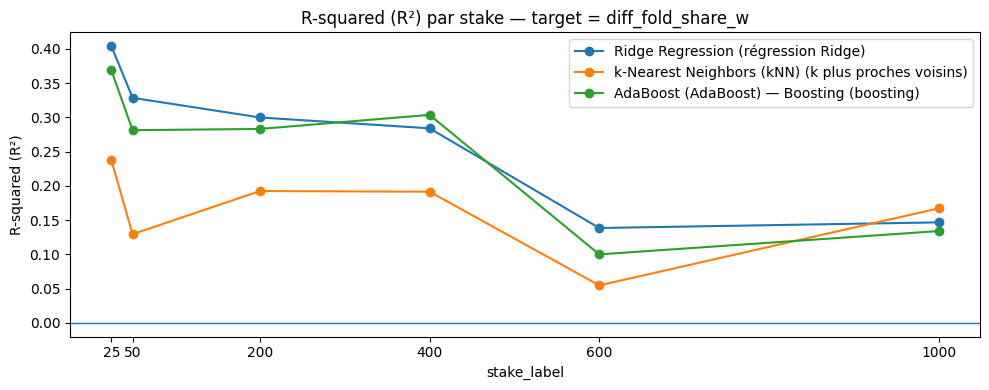

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/r2_by_stake_diff_fold_share_w.png


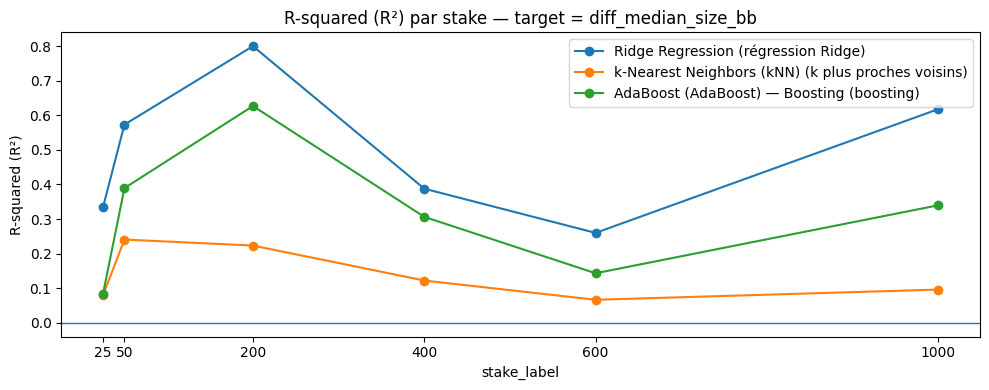

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/r2_by_stake_diff_median_size_bb.png

Figures saved in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final


In [9]:
# =========================
# BLOCK 8 — Final comparison table + 2 figures (R² by stake/model) [ROBUST VERSION]
# =========================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")

ridge_path = base_out / "ml_ridge_oof_vs_baseline_stake_by_stake.csv"
knn_path   = base_out / "ml_knn_oof_vs_baseline_stake_by_stake.csv"
ada_path   = base_out / "ml_adaboost_oof_vs_baseline_stake_by_stake.csv"

print("Reading:")
print("-", ridge_path)
print("-", knn_path)
print("-", ada_path)

df_ridge = pd.read_csv(ridge_path)
df_knn   = pd.read_csv(knn_path)
df_ada   = pd.read_csv(ada_path)

print("\nColumns check (first file):")
print("Ridge columns:", list(df_ridge.columns))
print("kNN columns:", list(df_knn.columns))
print("AdaBoost columns:", list(df_ada.columns))

def normalize(df, model_label):
    df = df.copy()
    df["model"] = model_label

    # Map model-specific metric columns -> generic MSE/MAE/R2
    if model_label.startswith("Ridge"):
        df["MSE"] = df["Ridge Mean Squared Error (MSE)"]
        df["MAE"] = df["Ridge Mean Absolute Error (MAE)"]
        df["R2"]  = df["Ridge R-squared (R²)"]
    elif model_label.startswith("k-Nearest"):
        df["MSE"] = df["kNN Mean Squared Error (MSE)"]
        df["MAE"] = df["kNN Mean Absolute Error (MAE)"]
        df["R2"]  = df["kNN R-squared (R²)"]
    elif model_label.startswith("AdaBoost"):
        df["MSE"] = df["AdaBoost Mean Squared Error (MSE)"]
        df["MAE"] = df["AdaBoost Mean Absolute Error (MAE)"]
        df["R2"]  = df["AdaBoost R-squared (R²)"]
    else:
        raise ValueError("Unknown model label.")

    # Baseline columns (should exist)
    df["Baseline_MSE"] = df["Baseline Mean Squared Error (MSE)"]
    df["Baseline_MAE"] = df["Baseline Mean Absolute Error (MAE)"]
    df["Baseline_R2"]  = df["Baseline R-squared (R²)"]

    # Always compute improvement (robust; avoids KeyError)
    df["MSE improvement vs baseline (%)"] = np.where(
        df["Baseline_MSE"] > 0,
        100.0 * (df["Baseline_MSE"] - df["MSE"]) / df["Baseline_MSE"],
        np.nan
    )

    keep = [
        "stake_label", "target", "n_events", "n_players", "n_splits", "model",
        "MSE", "MAE", "R2",
        "Baseline_MSE", "Baseline_MAE", "Baseline_R2",
        "MSE improvement vs baseline (%)"
    ]
    # some files might miss n_splits; fallback if needed
    for col in ["n_events", "n_players", "n_splits"]:
        if col not in df.columns:
            df[col] = np.nan

    return df[keep]

df_ridge_n = normalize(df_ridge, "Ridge Regression (régression Ridge)")
df_knn_n   = normalize(df_knn,   "k-Nearest Neighbors (kNN) (k plus proches voisins)")
df_ada_n   = normalize(df_ada,   "AdaBoost (AdaBoost) — Boosting (boosting)")

all_models = pd.concat([df_ridge_n, df_knn_n, df_ada_n], ignore_index=True)
all_models = all_models.sort_values(["target", "stake_label", "model"]).reset_index(drop=True)

out_table = base_out / "ml_final_model_comparison_stake_by_stake.csv"
all_models.to_csv(out_table, index=False)
print("\nSaved final comparison table to:", out_table)

print("\n=== FINAL COMPARISON (first 30 rows) ===")
print(all_models.head(30))

# Best model per stake/target by MSE
best_by_mse = (
    all_models.sort_values(["target", "stake_label", "MSE"], ascending=[True, True, True])
             .groupby(["target", "stake_label"], as_index=False)
             .first()
)

out_best = base_out / "ml_best_model_by_mse_stake_by_stake.csv"
best_by_mse.to_csv(out_best, index=False)
print("\nSaved best-by-MSE table to:", out_best)

print("\n=== BEST MODEL PER STAKE/TARGET (by MSE) ===")
print(best_by_mse[["stake_label","target","model","MSE","MAE","R2","MSE improvement vs baseline (%)"]])

# ---- 2 Figures: R² by stake for each target ----
fig_dir = base_out / "ml_figures_final"
fig_dir.mkdir(parents=True, exist_ok=True)

def plot_r2(target_name, filename):
    dfp = all_models[all_models["target"] == target_name].copy()
    stakes = sorted(dfp["stake_label"].unique())

    models = [
        "Ridge Regression (régression Ridge)",
        "k-Nearest Neighbors (kNN) (k plus proches voisins)",
        "AdaBoost (AdaBoost) — Boosting (boosting)",
    ]

    piv = dfp.pivot_table(index="stake_label", columns="model", values="R2", aggfunc="mean").reindex(stakes)

    plt.figure(figsize=(10, 4))
    for m in models:
        if m in piv.columns:
            plt.plot(piv.index, piv[m].values, marker="o", label=m)

    plt.axhline(0, linewidth=1)
    plt.title(f"R-squared (R²) par stake — target = {target_name}")
    plt.xlabel("stake_label")
    plt.ylabel("R-squared (R²)")
    plt.xticks(stakes)
    plt.legend()
    plt.tight_layout()

    out_png = fig_dir / filename
    plt.savefig(out_png, dpi=160)
    plt.show()
    print("Saved figure:", out_png)

plot_r2("diff_fold_share_w", "r2_by_stake_diff_fold_share_w.png")
plot_r2("diff_median_size_bb", "r2_by_stake_diff_median_size_bb.png")

print("\nFigures saved in:", fig_dir)


Loading: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

Features used: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']
Targets: ['diff_fold_share_w', 'diff_median_size_bb']
Stakes: [25, 50, 200, 400, 600, 1000]
GroupKFold splits: 5, Ridge alpha=1.0

Saved coefficients table to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_ridge_coefficients_groupkfold_stake_by_stake.csv

Preview (top 15 by abs coef):
    stake_label             target             feature  coef_mean  coef_std  \
2            25  diff_fold_share_w    pre_fold_share_w  -0.136669  0.012141   
8            25  diff_fold_share_w     n_decisions_pre  -0.046438  0.012599   
7            25  diff_fold_share_w         n_hands_pre   0.040486  0.012074   
0            25  diff_fold_sha

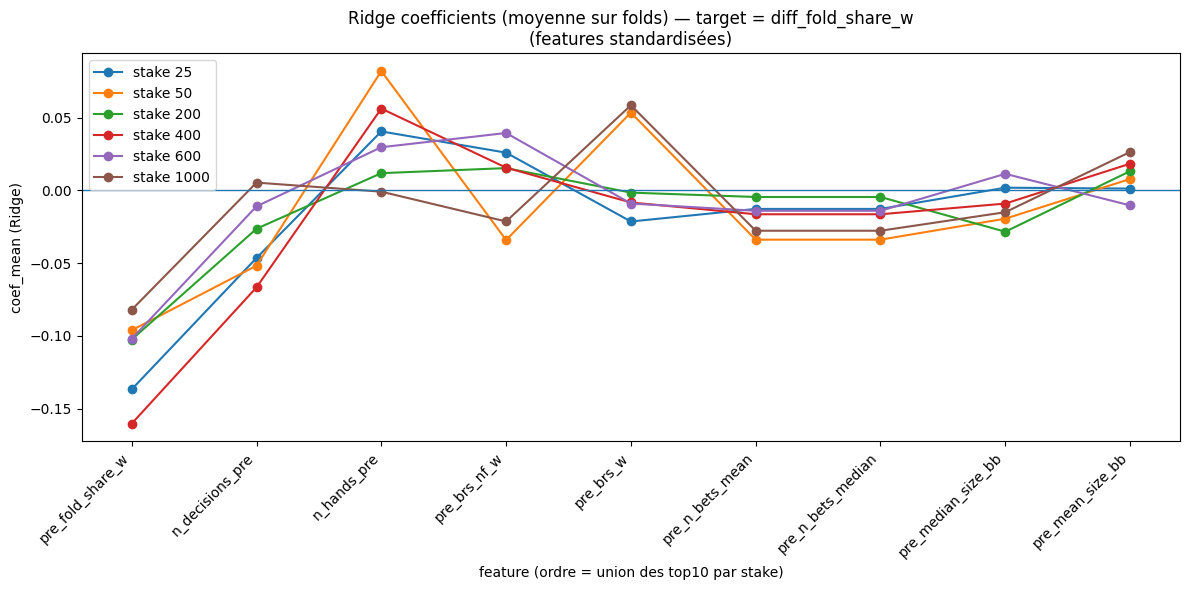

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_coeffs_top_union_diff_fold_share_w.png


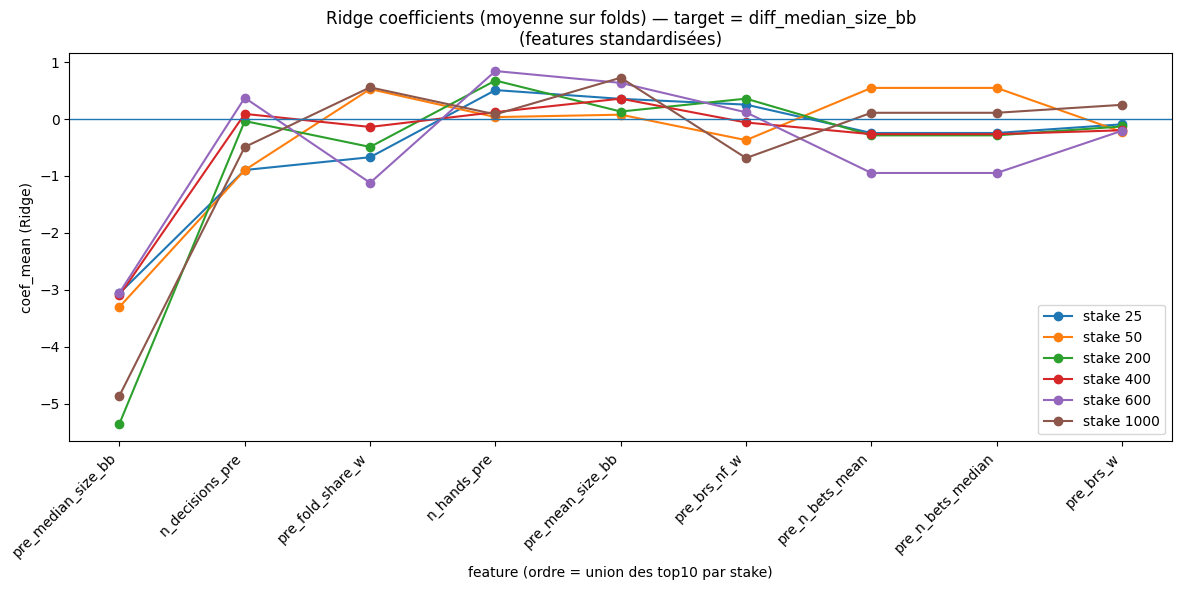

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_coeffs_top_union_diff_median_size_bb.png

Done. Figures in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final


In [10]:
# =========================
# BLOCK 9 — Ridge interpretability: mean coefficients across GroupKFold (stake-by-stake)
# =========================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# ---- Paths ----
base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")
ml_parquet = base_out / "ml_events.parquet"

print("Loading:", ml_parquet)
ml = pd.read_parquet(ml_parquet)

# ---- Settings ----
FEATURES = [
    "pre_brs_nf_w", "pre_brs_w", "pre_fold_share_w",
    "pre_mean_size_bb", "pre_median_size_bb",
    "pre_n_bets_mean", "pre_n_bets_median",
    "n_hands_pre", "n_decisions_pre"
]

TARGETS = ["diff_fold_share_w", "diff_median_size_bb"]
STAKES = sorted(ml["stake_label"].dropna().unique().tolist())

N_SPLITS = 5
ALPHA = 1.0  # same spirit as earlier Ridge; we can tune later, but keep fixed for interpretability

print("\nFeatures used:", FEATURES)
print("Targets:", TARGETS)
print("Stakes:", STAKES)
print(f"GroupKFold splits: {N_SPLITS}, Ridge alpha={ALPHA}")

# ---- Helper: fit ridge across folds and collect coefficients ----
def ridge_fold_coefs(df, target_col):
    df = df.copy()

    # drop rows with missing target or missing any feature
    cols_needed = FEATURES + [target_col, "player_id"]
    df = df.dropna(subset=cols_needed)

    X = df[FEATURES].values
    y = df[target_col].values
    groups = df["player_id"].values

    gkf = GroupKFold(n_splits=N_SPLITS)

    coefs = []
    for fold_idx, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
        # pipeline: scale -> ridge
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=ALPHA))
        ])
        pipe.fit(X[tr], y[tr])

        coef = pipe.named_steps["ridge"].coef_
        coefs.append(coef)

    coefs = np.vstack(coefs)  # shape (n_splits, n_features)
    coef_mean = coefs.mean(axis=0)
    coef_std  = coefs.std(axis=0)

    return coef_mean, coef_std, len(df), df["player_id"].nunique()

# ---- Compute coefficient summaries for every stake x target ----
rows = []
for stake in STAKES:
    df_s = ml[ml["stake_label"] == stake]
    for target in TARGETS:
        coef_mean, coef_std, n_rows, n_players = ridge_fold_coefs(df_s, target)
        for feat, m, s in zip(FEATURES, coef_mean, coef_std):
            rows.append({
                "stake_label": stake,
                "target": target,
                "feature": feat,
                "coef_mean": float(m),
                "coef_std": float(s),
                "abs_coef_mean": float(abs(m)),
                "n_events_used": int(n_rows),
                "n_players_used": int(n_players),
                "n_splits": N_SPLITS,
                "ridge_alpha": ALPHA
            })

coef_df = pd.DataFrame(rows)

# ---- Save coefficients table ----
coef_csv = base_out / "ml_ridge_coefficients_groupkfold_stake_by_stake.csv"
coef_df.to_csv(coef_csv, index=False)
print("\nSaved coefficients table to:", coef_csv)

print("\nPreview (top 15 by abs coef):")
print(coef_df.sort_values(["target","stake_label","abs_coef_mean"], ascending=[True, True, False]).head(15))

# ---- Plot: Top 10 coefficients per stake for each target ----
fig_dir = base_out / "ml_figures_final"
fig_dir.mkdir(parents=True, exist_ok=True)

def plot_top10(target_col, out_png):
    df_t = coef_df[coef_df["target"] == target_col].copy()

    stakes = sorted(df_t["stake_label"].unique())
    # For each stake, take top 10 features by abs coef
    top_map = {}
    for s in stakes:
        d = df_t[df_t["stake_label"] == s].sort_values("abs_coef_mean", ascending=False).head(10)
        top_map[s] = d

    # Build a consistent feature order: union of all top features across stakes
    feat_union = []
    for s in stakes:
        for f in top_map[s]["feature"].tolist():
            if f not in feat_union:
                feat_union.append(f)

    # Pivot coef_mean for plotting
    piv = df_t.pivot_table(index="feature", columns="stake_label", values="coef_mean", aggfunc="mean")
    piv = piv.reindex(feat_union)

    plt.figure(figsize=(12, 6))
    for s in stakes:
        if s in piv.columns:
            plt.plot(range(len(piv.index)), piv[s].values, marker="o", label=f"stake {s}")

    plt.axhline(0, linewidth=1)
    plt.title(f"Ridge coefficients (moyenne sur folds) — target = {target_col}\n(features standardisées)")
    plt.xlabel("feature (ordre = union des top10 par stake)")
    plt.ylabel("coef_mean (Ridge)")
    plt.xticks(range(len(piv.index)), piv.index, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()

    out_path = fig_dir / out_png
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved figure:", out_path)

plot_top10("diff_fold_share_w", "ridge_coeffs_top_union_diff_fold_share_w.png")
plot_top10("diff_median_size_bb", "ridge_coeffs_top_union_diff_median_size_bb.png")

print("\nDone. Figures in:", fig_dir)


Loading: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

Features: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']
Targets: ['diff_fold_share_w', 'diff_median_size_bb']
GroupKFold splits: 5, Ridge alpha=1.0
Stakes: [25, 50, 200, 400, 600, 1000]

Saved OOF predictions to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_ridge_oof_predictions_stake_by_stake.csv
Saved OOF metrics to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_ridge_oof_metrics_stake_by_stake.csv

OOF metrics (preview):
    stake_label               target  n_events_used  n_players_used  n_splits  \
0            25    diff_fold_share_w            207             124         5   
2            50    diff_fold_share_w        

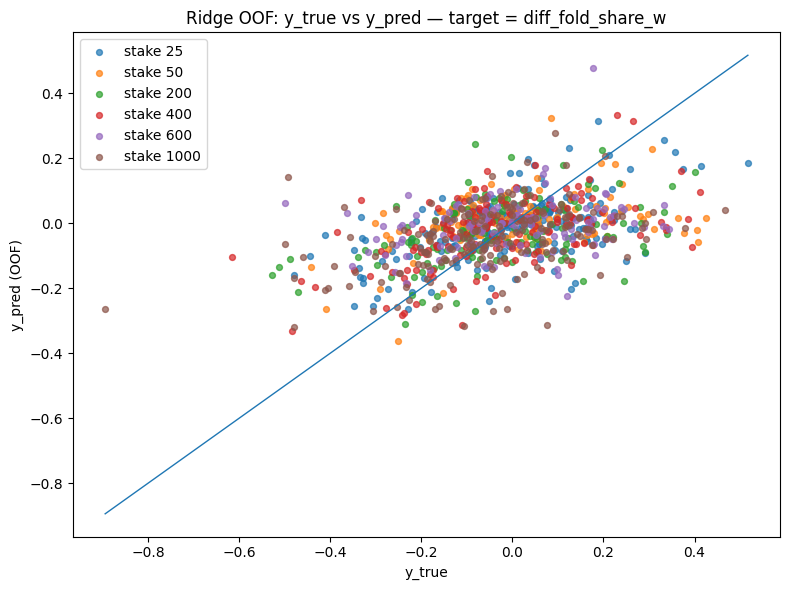

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_oof_true_vs_pred_diff_fold_share_w.png


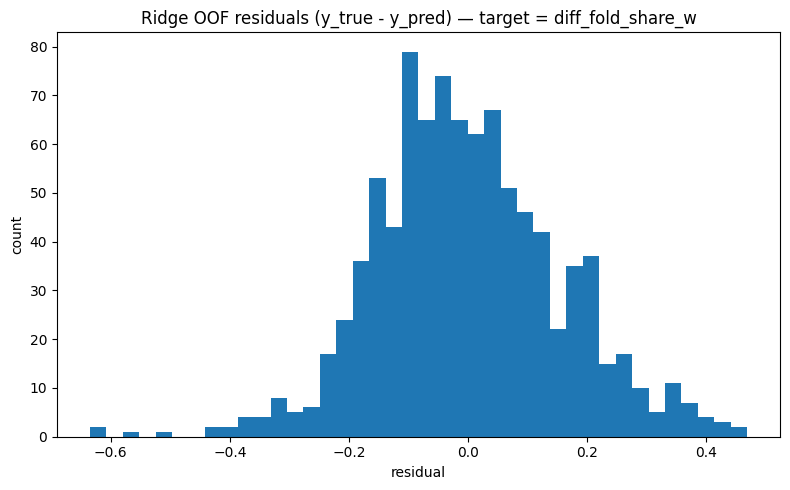

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_oof_residuals_diff_fold_share_w.png


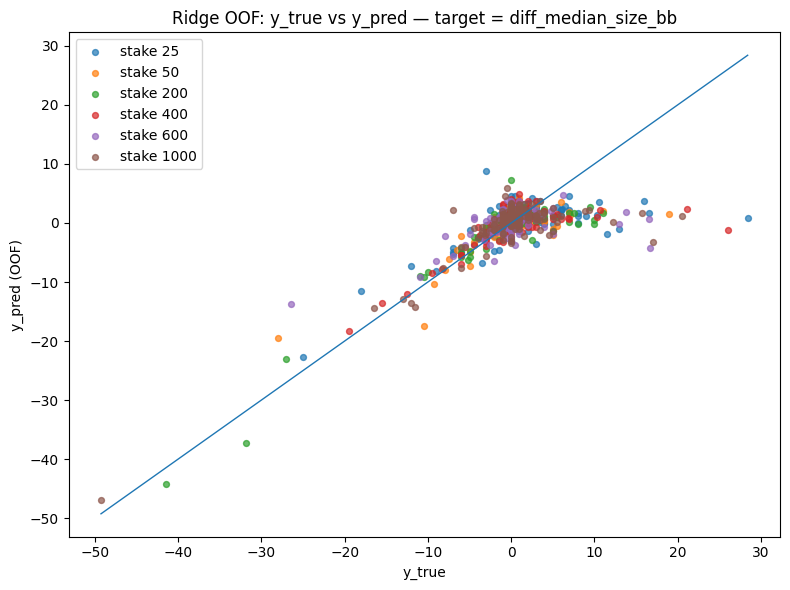

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_oof_true_vs_pred_diff_median_size_bb.png


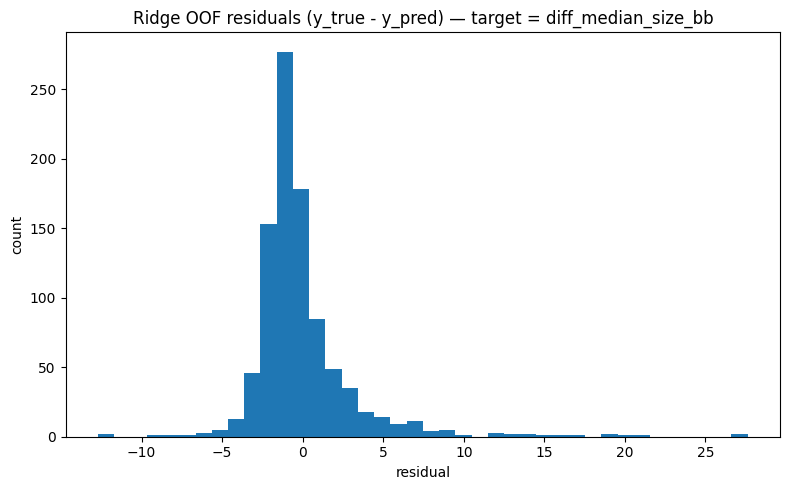

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/ridge_oof_residuals_diff_median_size_bb.png

Done. Figures saved in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final


In [11]:
# =========================
# BLOCK 10 — Ridge OOF predictions (GroupKFold by player) stake-by-stake + diagnostic plots
# =========================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- Paths ----
base_out = Path("/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/")
ml_parquet = base_out / "ml_events.parquet"

fig_dir = base_out / "ml_figures_final"
fig_dir.mkdir(parents=True, exist_ok=True)

print("Loading:", ml_parquet)
ml = pd.read_parquet(ml_parquet)

# ---- Settings ----
FEATURES = [
    "pre_brs_nf_w", "pre_brs_w", "pre_fold_share_w",
    "pre_mean_size_bb", "pre_median_size_bb",
    "pre_n_bets_mean", "pre_n_bets_median",
    "n_hands_pre", "n_decisions_pre"
]
TARGETS = ["diff_fold_share_w", "diff_median_size_bb"]

N_SPLITS = 5
ALPHA = 1.0

print("\nFeatures:", FEATURES)
print("Targets:", TARGETS)
print(f"GroupKFold splits: {N_SPLITS}, Ridge alpha={ALPHA}")

def ridge_oof_for_stake(df_stake, target_col):
    # Drop missing
    needed = FEATURES + [target_col, "player_id", "stake_label"]
    df = df_stake.dropna(subset=needed).copy()

    X = df[FEATURES].values
    y = df[target_col].values
    groups = df["player_id"].values

    gkf = GroupKFold(n_splits=N_SPLITS)

    y_pred_oof = np.full_like(y, fill_value=np.nan, dtype=float)

    for fold_idx, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=ALPHA))
        ])
        pipe.fit(X[tr], y[tr])
        y_pred_oof[te] = pipe.predict(X[te])

    # Metrics on OOF
    mse = mean_squared_error(y, y_pred_oof)
    mae = mean_absolute_error(y, y_pred_oof)
    r2  = r2_score(y, y_pred_oof)

    out = df[["stake_label", "player_id"]].copy()
    out["target"] = target_col
    out["y_true"] = y
    out["y_pred"] = y_pred_oof
    out["residual"] = out["y_true"] - out["y_pred"]

    return out, mse, mae, r2, len(df), df["player_id"].nunique()

# ---- Compute OOF for each stake x target ----
all_oof = []
rows_metrics = []

stakes = sorted(ml["stake_label"].dropna().unique().tolist())
print("Stakes:", stakes)

for stake in stakes:
    df_s = ml[ml["stake_label"] == stake]
    for target in TARGETS:
        oof_df, mse, mae, r2, n_ev, n_pl = ridge_oof_for_stake(df_s, target)
        all_oof.append(oof_df)
        rows_metrics.append({
            "stake_label": stake,
            "target": target,
            "n_events_used": n_ev,
            "n_players_used": n_pl,
            "n_splits": N_SPLITS,
            "ridge_alpha": ALPHA,
            "Mean Squared Error (MSE)": float(mse),
            "Mean Absolute Error (MAE)": float(mae),
            "R-squared (R²)": float(r2)
        })

oof_all = pd.concat(all_oof, ignore_index=True)
metrics_df = pd.DataFrame(rows_metrics).sort_values(["target", "stake_label"])

# ---- Save OOF + metrics ----
oof_csv = base_out / "ml_ridge_oof_predictions_stake_by_stake.csv"
metrics_csv = base_out / "ml_ridge_oof_metrics_stake_by_stake.csv"
oof_all.to_csv(oof_csv, index=False)
metrics_df.to_csv(metrics_csv, index=False)

print("\nSaved OOF predictions to:", oof_csv)
print("Saved OOF metrics to:", metrics_csv)

print("\nOOF metrics (preview):")
print(metrics_df)

# ---- Plots: y_true vs y_pred (OOF), and residual histogram ----
def plot_true_vs_pred(target_col, out_png):
    df = oof_all[oof_all["target"] == target_col].copy()

    plt.figure(figsize=(8, 6))
    for stake in sorted(df["stake_label"].unique()):
        d = df[df["stake_label"] == stake]
        plt.scatter(d["y_true"], d["y_pred"], s=18, alpha=0.7, label=f"stake {stake}")

    # y=x reference line
    lo = np.nanmin([df["y_true"].min(), df["y_pred"].min()])
    hi = np.nanmax([df["y_true"].max(), df["y_pred"].max()])
    plt.plot([lo, hi], [lo, hi], linewidth=1)

    plt.title(f"Ridge OOF: y_true vs y_pred — target = {target_col}")
    plt.xlabel("y_true")
    plt.ylabel("y_pred (OOF)")
    plt.legend()
    plt.tight_layout()

    out_path = fig_dir / out_png
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved figure:", out_path)

def plot_residuals(target_col, out_png):
    df = oof_all[oof_all["target"] == target_col].copy()

    plt.figure(figsize=(8, 5))
    plt.hist(df["residual"].values, bins=40)
    plt.title(f"Ridge OOF residuals (y_true - y_pred) — target = {target_col}")
    plt.xlabel("residual")
    plt.ylabel("count")
    plt.tight_layout()

    out_path = fig_dir / out_png
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved figure:", out_path)

plot_true_vs_pred("diff_fold_share_w", "ridge_oof_true_vs_pred_diff_fold_share_w.png")
plot_residuals("diff_fold_share_w", "ridge_oof_residuals_diff_fold_share_w.png")

plot_true_vs_pred("diff_median_size_bb", "ridge_oof_true_vs_pred_diff_median_size_bb.png")
plot_residuals("diff_median_size_bb", "ridge_oof_residuals_diff_median_size_bb.png")

print("\nDone. Figures saved in:", fig_dir)


=== Loading: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet
Features used: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']
Targets: ['diff_fold_share_w', 'diff_median_size_bb']
Stakes: [25, 50, 200, 400, 600, 1000]
GroupKFold splits: 5, kNN n_neighbors=15

Saved OOF predictions to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_knn_oof_predictions_stake_by_stake.csv
Saved OOF metrics to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_knn_oof_metrics_stake_by_stake.csv

OOF metrics (preview):


,stake_label,target,model,n_events_used,n_players_used,n_splits,knn_n_neighbors,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared (R²),Baseline Mean Squared Error (MSE),Baseline Mean Absolute Error (MAE),Baseline R-squared (R²),MSE improvement vs baseline (%)
0,25,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,207,124,5,15,0.022647,0.116903,0.165301,0.027369,0.128548,-0.008730,17.252497
2,50,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,126,83,5,15,0.028230,0.132410,0.010905,0.028963,0.132847,-0.014775,2.530585
4,200,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,141,100,5,15,0.025463,0.125300,0.137755,0.029970,0.133945,-0.014865,15.038454
6,400,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,157,91,5,15,0.023429,0.119993,0.250279,0.031268,0.136986,-0.000564,25.070187
8,600,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,122,82,5,15,0.026561,0.128684,0.016235,0.027357,0.132236,-0.013220,2.907118
10,1000,diff_fold_share_w,k-Nearest Neighbors (kNN) (k plus proches vois...,174,96,5,15,0.028488,0.126511,0.160724,0.034567,0.139103,-0.018347,17.584511
1,25,diff_median_size_bb,k-Nearest Neighbors (kNN) (k plus proches vois...,207,124,5,15,19.125483,2.690145,0.079193,21.090197,2.576191,-0.015399,9.315769
3,50,diff_median_size_bb,k-Nearest Neighbors (kNN) (k plus proches vois...,126,83,5,15,13.494966,2.149153,0.240715,17.823322,2.257180,-0.002817,24.284786
5,200,diff_median_size_bb,k-Nearest Neighbors (kNN) (k plus proches vois...,141,100,5,15,27.365332,2.784054,0.223279,35.454343,2.830091,-0.006314,22.815290
7,400,diff_median_size_bb,k-Nearest Neighbors (kNN) (k plus proches vois...,157,91,5,15,16.059193,2.186176,0.122131,18.390031,2.059267,-0.005283,12.674467


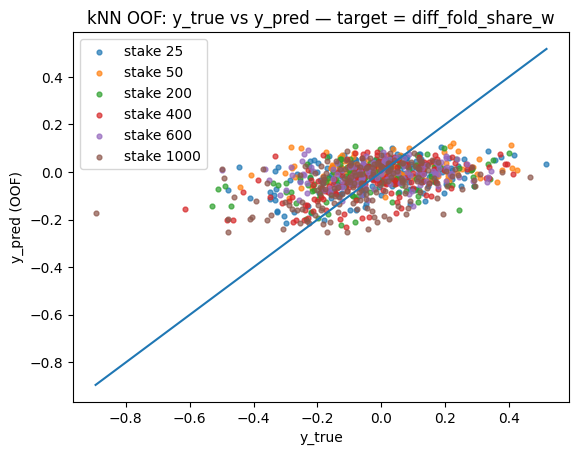

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/knn_oof_true_vs_pred_diff_fold_share_w.png


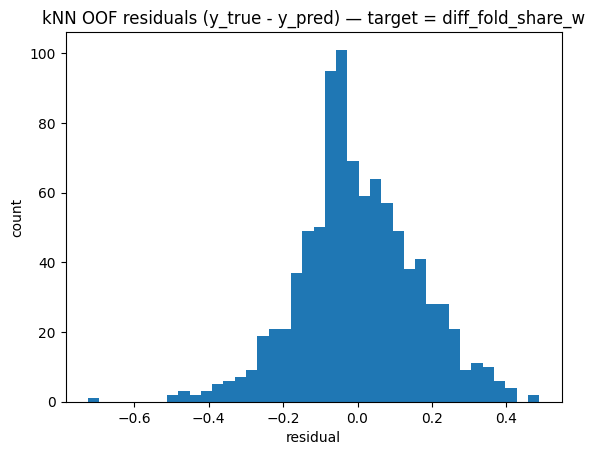

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/knn_oof_residuals_diff_fold_share_w.png


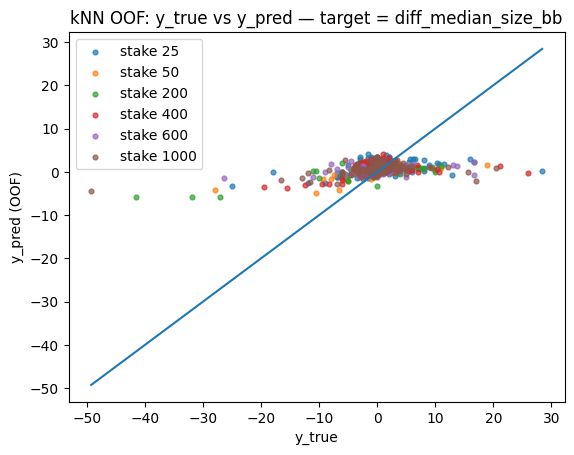

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/knn_oof_true_vs_pred_diff_median_size_bb.png


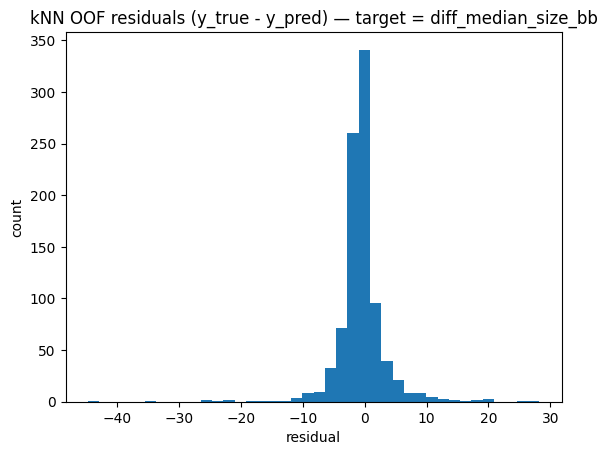

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/knn_oof_residuals_diff_median_size_bb.png

Done. Figures in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# ======================
# Paths (adapte seulement si besoin)
# ======================
ML_EVENTS_PATH = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet"
EXPORT_DIR = os.path.dirname(ML_EVENTS_PATH)
FIG_DIR = os.path.join(EXPORT_DIR, "ml_figures_final")
os.makedirs(FIG_DIR, exist_ok=True)

print(f"=== Loading: {ML_EVENTS_PATH}")
df = pd.read_parquet(ML_EVENTS_PATH)

# ======================
# Config
# ======================
FEATURES = [
    "pre_brs_nf_w", "pre_brs_w", "pre_fold_share_w",
    "pre_mean_size_bb", "pre_median_size_bb",
    "pre_n_bets_mean", "pre_n_bets_median",
    "n_hands_pre", "n_decisions_pre"
]

TARGETS = ["diff_fold_share_w", "diff_median_size_bb"]

# Stake-by-stake (on ne mélange pas)
STAKES = sorted(df["stake_label"].dropna().unique().tolist())

# Group split: IMPORTANT anti-leakage
GROUP_COL = "player_id"

# kNN hyperparameter (reprend ton run)
KNN_N_NEIGHBORS = 15
N_SPLITS = 5

print("Features used:", FEATURES)
print("Targets:", TARGETS)
print("Stakes:", STAKES)
print(f"GroupKFold splits: {N_SPLITS}, kNN n_neighbors={KNN_N_NEIGHBORS}")

# ======================
# Helper: OOF predictions + fold-wise baseline
# ======================
def oof_predict_and_metrics(X, y, groups, model, n_splits=5):
    gkf = GroupKFold(n_splits=n_splits)

    y_pred = np.full(len(y), np.nan, dtype=float)
    y_base = np.full(len(y), np.nan, dtype=float)

    for fold_idx, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        # fit model
        model.fit(X_tr, y_tr)
        y_pred[te] = model.predict(X_te)

        # baseline: mean of y on TRAIN fold (no leakage)
        y_base[te] = float(y_tr.mean())

    # Metrics
    resid = y.values - y_pred
    mse = float(np.mean(resid ** 2))
    mae = float(np.mean(np.abs(resid)))

    # R² = 1 - SSE/SST
    sse = float(np.sum((y.values - y_pred) ** 2))
    sst = float(np.sum((y.values - y.values.mean()) ** 2))
    r2 = float(1.0 - sse / sst) if sst > 0 else np.nan

    # Baseline metrics
    resid_b = y.values - y_base
    mse_b = float(np.mean(resid_b ** 2))
    mae_b = float(np.mean(np.abs(resid_b)))
    sse_b = float(np.sum((y.values - y_base) ** 2))
    r2_b = float(1.0 - sse_b / sst) if sst > 0 else np.nan

    return y_pred, y_base, {"mse": mse, "mae": mae, "r2": r2, "mse_b": mse_b, "mae_b": mae_b, "r2_b": r2_b}

# ======================
# Run stake-by-stake
# ======================
all_preds = []
rows = []

knn_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=KNN_N_NEIGHBORS))
])

for stake in STAKES:
    df_s = df[df["stake_label"] == stake].copy()

    # on garde uniquement lignes avec FEATURES complets
    df_s = df_s.dropna(subset=FEATURES + [GROUP_COL, "event_hand_id"])

    for target in TARGETS:
        df_st = df_s.dropna(subset=[target]).copy()
        n_events = len(df_st)
        n_players = df_st[GROUP_COL].nunique()

        if n_events < N_SPLITS:
            print(f"[WARN] stake={stake} target={target}: n_events={n_events} < n_splits={N_SPLITS} -> skip")
            continue

        X = df_st[FEATURES]
        y = df_st[target]
        groups = df_st[GROUP_COL]

        y_pred, y_base, m = oof_predict_and_metrics(X, y, groups, knn_model, n_splits=N_SPLITS)

        # store predictions
        tmp = df_st[["stake_label", "player_id", "event_hand_id"]].copy()
        tmp["model"] = "k-Nearest Neighbors (kNN) (k plus proches voisins)"
        tmp["target"] = target
        tmp["y_true"] = y.values
        tmp["y_pred_oof"] = y_pred
        tmp["y_baseline_oof"] = y_base
        all_preds.append(tmp)

        # store metrics
        rows.append({
            "stake_label": stake,
            "target": target,
            "model": "k-Nearest Neighbors (kNN) (k plus proches voisins)",
            "n_events_used": n_events,
            "n_players_used": n_players,
            "n_splits": N_SPLITS,
            "knn_n_neighbors": KNN_N_NEIGHBORS,
            "Mean Squared Error (MSE)": m["mse"],
            "Mean Absolute Error (MAE)": m["mae"],
            "R-squared (R²)": m["r2"],
            "Baseline Mean Squared Error (MSE)": m["mse_b"],
            "Baseline Mean Absolute Error (MAE)": m["mae_b"],
            "Baseline R-squared (R²)": m["r2_b"],
            "MSE improvement vs baseline (%)": 100.0 * (m["mse_b"] - m["mse"]) / m["mse_b"] if m["mse_b"] > 0 else np.nan
        })

# ======================
# Save outputs
# ======================
preds_df = pd.concat(all_preds, ignore_index=True) if len(all_preds) else pd.DataFrame()
metrics_df = pd.DataFrame(rows)

preds_path = os.path.join(EXPORT_DIR, "ml_knn_oof_predictions_stake_by_stake.csv")
metrics_path = os.path.join(EXPORT_DIR, "ml_knn_oof_metrics_stake_by_stake.csv")

preds_df.to_csv(preds_path, index=False)
metrics_df.to_csv(metrics_path, index=False)

print(f"\nSaved OOF predictions to: {preds_path}")
print(f"Saved OOF metrics to: {metrics_path}")

print("\nOOF metrics (preview):")
display(metrics_df.sort_values(["target", "stake_label"]))

# ======================
# Figures (aggregated across stakes, colored by stake)
# ======================
for target in TARGETS:
    sub = preds_df[preds_df["target"] == target].copy()
    if sub.empty:
        continue

    # y_true vs y_pred
    plt.figure()
    for stake in sorted(sub["stake_label"].unique()):
        ss = sub[sub["stake_label"] == stake]
        plt.scatter(ss["y_true"], ss["y_pred_oof"], s=12, alpha=0.7, label=f"stake {stake}")
    # diagonal
    lo = float(np.nanmin(sub[["y_true", "y_pred_oof"]].values))
    hi = float(np.nanmax(sub[["y_true", "y_pred_oof"]].values))
    plt.plot([lo, hi], [lo, hi])
    plt.title(f"kNN OOF: y_true vs y_pred — target = {target}")
    plt.xlabel("y_true")
    plt.ylabel("y_pred (OOF)")
    plt.legend()
    fig_path = os.path.join(FIG_DIR, f"knn_oof_true_vs_pred_{target}.png")
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")

    # residuals histogram
    resid = sub["y_true"] - sub["y_pred_oof"]
    plt.figure()
    plt.hist(resid.dropna().values, bins=40)
    plt.title(f"kNN OOF residuals (y_true - y_pred) — target = {target}")
    plt.xlabel("residual")
    plt.ylabel("count")
    fig_path = os.path.join(FIG_DIR, f"knn_oof_residuals_{target}.png")
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")

print(f"\nDone. Figures in: {FIG_DIR}")


=== Loading: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

Features used: ['pre_brs_nf_w', 'pre_brs_w', 'pre_fold_share_w', 'pre_mean_size_bb', 'pre_median_size_bb', 'pre_n_bets_mean', 'pre_n_bets_median', 'n_hands_pre', 'n_decisions_pre']
Targets: ['diff_fold_share_w', 'diff_median_size_bb']
Stakes: [25, 50, 200, 400, 600, 1000]
GroupKFold splits: 5, AdaBoost n_estimators=400, learning_rate=0.05, base_tree_max_depth=2, min_samples_leaf=5



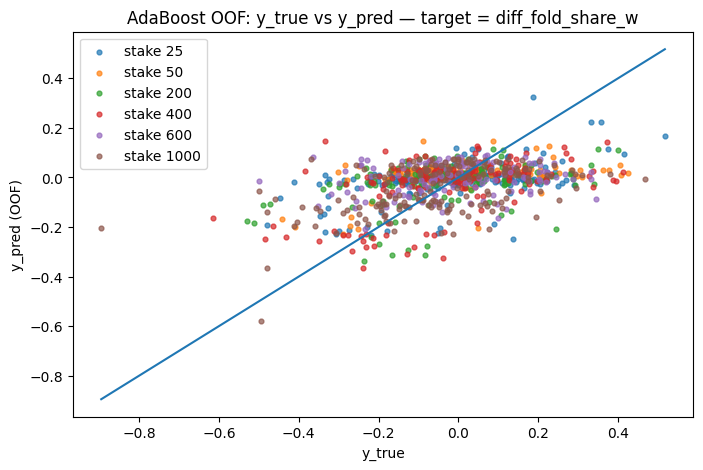

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/adaboost_oof_true_vs_pred_diff_fold_share_w.png


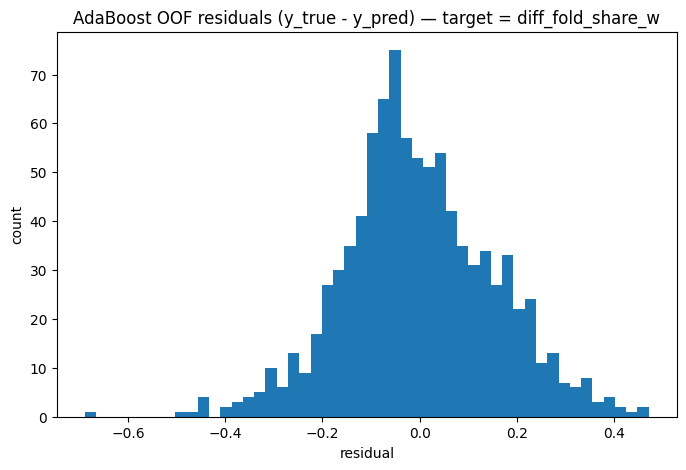

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/adaboost_oof_residuals_diff_fold_share_w.png



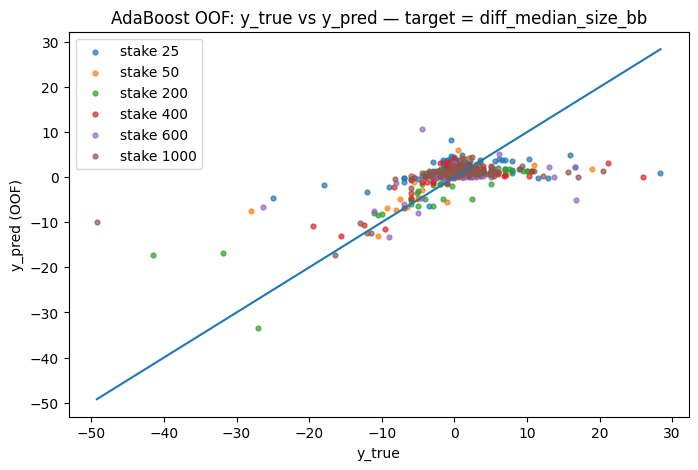

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/adaboost_oof_true_vs_pred_diff_median_size_bb.png


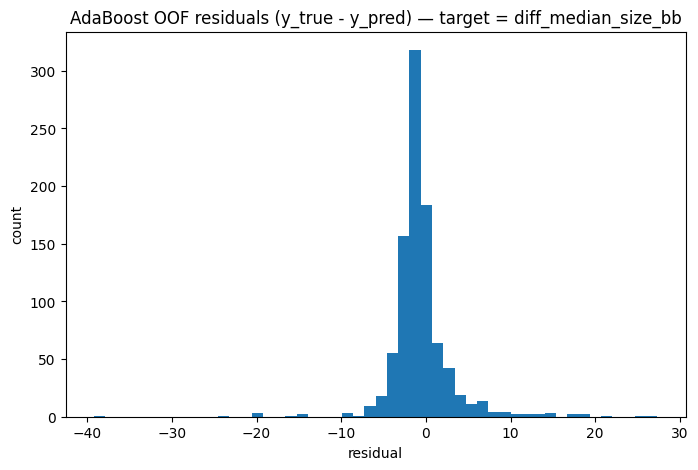

Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final/adaboost_oof_residuals_diff_median_size_bb.png


Saved OOF predictions to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_adaboost_oof_predictions_stake_by_stake.csv
Saved OOF metrics to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_adaboost_oof_metrics_stake_by_stake.csv
Done. Figures saved in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_final

OOF metrics (preview):


,stake_label,target,n_events_used,n_players_used,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared (R²),Baseline Mean Squared Error (MSE),Baseline Mean Absolute Error (MAE),MSE improvement vs baseline (%)
0,25,diff_fold_share_w,207,124,0.020380,0.113494,0.248857,0.027369,0.128548,25.535772
1,50,diff_fold_share_w,126,83,0.024543,0.125058,0.140082,0.028963,0.132847,15.260229
2,200,diff_fold_share_w,141,100,0.025775,0.127335,0.127209,0.029970,0.133945,13.999310
3,400,diff_fold_share_w,157,91,0.023808,0.120205,0.238163,0.031268,0.136986,23.859179
4,600,diff_fold_share_w,122,82,0.027460,0.131440,-0.017041,0.027357,0.132236,-0.377132
5,1000,diff_fold_share_w,174,96,0.026175,0.122980,0.228881,0.034567,0.139103,24.277393
6,25,diff_median_size_bb,207,124,19.029531,2.948067,0.083813,21.090197,2.576191,9.770731
7,50,diff_median_size_bb,126,83,10.850393,1.964738,0.389510,17.823322,2.257180,39.122499
8,200,diff_median_size_bb,141,100,13.145677,2.335548,0.626881,35.454343,2.830091,62.922239
9,400,diff_median_size_bb,157,91,12.689805,2.132302,0.306317,18.390031,2.059267,30.996286


In [13]:
# =========================================
# AdaBoost (AdaBoost) — Boosting (boosting)
# OOF predictions + diagnostic plots (stake-by-stake, GroupKFold by player_id)
# =========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# ---- Paths
EXPORT_DIR = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports"
DATA_PATH = os.path.join(EXPORT_DIR, "ml_events.parquet")

FIG_DIR = os.path.join(EXPORT_DIR, "ml_figures_final")
os.makedirs(FIG_DIR, exist_ok=True)

# ---- Fixed features/targets (as agreed)
FEATURES = [
    "pre_brs_nf_w", "pre_brs_w", "pre_fold_share_w",
    "pre_mean_size_bb", "pre_median_size_bb",
    "pre_n_bets_mean", "pre_n_bets_median",
    "n_hands_pre", "n_decisions_pre"
]
TARGETS = ["diff_fold_share_w", "diff_median_size_bb"]

N_SPLITS = 5
RANDOM_STATE = 42

# AdaBoost hyperparameters (same spirit as your previous block)
N_ESTIMATORS = 400
LEARNING_RATE = 0.05
BASE_TREE_MAX_DEPTH = 2
MIN_SAMPLES_LEAF = 5

print(f"=== Loading: {DATA_PATH}\n")
df = pd.read_parquet(DATA_PATH)

stakes = sorted(df["stake_label"].dropna().unique().tolist())
print(f"Features used: {FEATURES}")
print(f"Targets: {TARGETS}")
print(f"Stakes: {stakes}")
print(f"GroupKFold splits: {N_SPLITS}, AdaBoost n_estimators={N_ESTIMATORS}, learning_rate={LEARNING_RATE}, "
      f"base_tree_max_depth={BASE_TREE_MAX_DEPTH}, min_samples_leaf={MIN_SAMPLES_LEAF}\n")

gkf = GroupKFold(n_splits=N_SPLITS)

all_metrics = []
all_oof_rows = []

for target in TARGETS:
    # Collect OOF points across stakes for one global plot per target
    oof_points = []

    for stake in stakes:
        d = df[df["stake_label"] == stake].copy()

        # Keep only rows where target + all features + player_id are available
        keep_cols = ["player_id"] + FEATURES + [target]
        d = d[keep_cols].dropna()

        n_events = len(d)
        n_players = d["player_id"].nunique()

        if n_events < N_SPLITS or n_players < N_SPLITS:
            print(f"[SKIP] stake={stake}, target={target}: not enough data (events={n_events}, players={n_players})")
            continue

        X = d[FEATURES].to_numpy()
        y = d[target].to_numpy()
        groups = d["player_id"].to_numpy()

        # OOF containers
        y_pred_oof = np.full(shape=y.shape, fill_value=np.nan, dtype=float)
        y_pred_baseline_oof = np.full(shape=y.shape, fill_value=np.nan, dtype=float)

        # Model
        base_tree = DecisionTreeRegressor(
            max_depth=BASE_TREE_MAX_DEPTH,
            min_samples_leaf=MIN_SAMPLES_LEAF,
            random_state=RANDOM_STATE
        )
        model = AdaBoostRegressor(
            estimator=base_tree,
            n_estimators=N_ESTIMATORS,
            learning_rate=LEARNING_RATE,
            random_state=RANDOM_STATE
        )

        # GroupKFold OOF
        for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
            X_tr, y_tr = X[tr_idx], y[tr_idx]
            X_te, y_te = X[te_idx], y[te_idx]

            model.fit(X_tr, y_tr)
            y_pred_oof[te_idx] = model.predict(X_te)

            # Baseline: constant predictor = mean(y_train) for that fold
            y_pred_baseline_oof[te_idx] = np.mean(y_tr)

        # Metrics on OOF
        mse = mean_squared_error(y, y_pred_oof)
        mae = mean_absolute_error(y, y_pred_oof)
        r2 = r2_score(y, y_pred_oof)

        base_mse = mean_squared_error(y, y_pred_baseline_oof)
        base_mae = mean_absolute_error(y, y_pred_baseline_oof)
        base_r2 = r2_score(y, y_pred_baseline_oof)

        mse_impr_pct = 100.0 * (base_mse - mse) / base_mse if base_mse != 0 else np.nan

        all_metrics.append({
            "stake_label": int(stake),
            "target": target,
            "model": "AdaBoost (AdaBoost) — Boosting (boosting)",
            "n_events_used": int(n_events),
            "n_players_used": int(n_players),
            "n_splits": int(N_SPLITS),
            "n_estimators": int(N_ESTIMATORS),
            "learning_rate": float(LEARNING_RATE),
            "base_tree_max_depth": int(BASE_TREE_MAX_DEPTH),
            "min_samples_leaf": int(MIN_SAMPLES_LEAF),
            "Mean Squared Error (MSE)": float(mse),
            "Mean Absolute Error (MAE)": float(mae),
            "R-squared (R²)": float(r2),
            "Baseline Mean Squared Error (MSE)": float(base_mse),
            "Baseline Mean Absolute Error (MAE)": float(base_mae),
            "Baseline R-squared (R²)": float(base_r2),
            "MSE improvement vs baseline (%)": float(mse_impr_pct),
        })

        # Store OOF rows for export + plots
        tmp = d[["player_id"]].copy()
        tmp["stake_label"] = int(stake)
        tmp["target"] = target
        tmp["y_true"] = y
        tmp["y_pred_oof"] = y_pred_oof
        tmp["y_pred_baseline_oof"] = y_pred_baseline_oof
        all_oof_rows.append(tmp)

        oof_points.append((int(stake), y, y_pred_oof))

    # ---- Plots per target (across stakes)
    if len(oof_points) > 0:
        # Scatter y_true vs y_pred
        plt.figure(figsize=(8, 5))
        global_min = np.inf
        global_max = -np.inf
        for stake, y_true_s, y_pred_s in oof_points:
            global_min = min(global_min, np.min(y_true_s), np.min(y_pred_s))
            global_max = max(global_max, np.max(y_true_s), np.max(y_pred_s))
            plt.scatter(y_true_s, y_pred_s, s=12, alpha=0.7, label=f"stake {stake}")

        plt.plot([global_min, global_max], [global_min, global_max])
        plt.title(f"AdaBoost OOF: y_true vs y_pred — target = {target}")
        plt.xlabel("y_true")
        plt.ylabel("y_pred (OOF)")
        plt.legend()
        out_scatter = os.path.join(FIG_DIR, f"adaboost_oof_true_vs_pred_{target}.png")
        plt.savefig(out_scatter, bbox_inches="tight")
        plt.show()
        print(f"Saved figure: {out_scatter}")

        # Residuals histogram
        plt.figure(figsize=(8, 5))
        residuals = np.concatenate([y_true_s - y_pred_s for _, y_true_s, y_pred_s in oof_points])
        plt.hist(residuals, bins=50)
        plt.title(f"AdaBoost OOF residuals (y_true - y_pred) — target = {target}")
        plt.xlabel("residual")
        plt.ylabel("count")
        out_hist = os.path.join(FIG_DIR, f"adaboost_oof_residuals_{target}.png")
        plt.savefig(out_hist, bbox_inches="tight")
        plt.show()
        print(f"Saved figure: {out_hist}\n")

# ---- Exports
df_metrics = pd.DataFrame(all_metrics).sort_values(["target", "stake_label"]).reset_index(drop=True)
out_metrics = os.path.join(EXPORT_DIR, "ml_adaboost_oof_metrics_stake_by_stake.csv")
df_metrics.to_csv(out_metrics, index=False)

df_oof = pd.concat(all_oof_rows, ignore_index=True) if len(all_oof_rows) else pd.DataFrame()
out_oof = os.path.join(EXPORT_DIR, "ml_adaboost_oof_predictions_stake_by_stake.csv")
df_oof.to_csv(out_oof, index=False)

print(f"\nSaved OOF predictions to: {out_oof}")
print(f"Saved OOF metrics to: {out_metrics}")
print(f"Done. Figures saved in: {FIG_DIR}\n")

print("OOF metrics (preview):")
display(df_metrics[[
    "stake_label", "target", "n_events_used", "n_players_used",
    "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R²)",
    "Baseline Mean Squared Error (MSE)", "Baseline Mean Absolute Error (MAE)",
    "MSE improvement vs baseline (%)"
]])


In [14]:
# === Sanity checks (report-friendly) ===
# 1) Dataset coverage per stake/target (n_events, n_players)
# 2) GroupKFold integrity check: no player_id overlap between train/test folds
# 3) Small plots: sample size by stake (helps explain performance differences)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

BASE_DIR = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports"
PARQUET_PATH = os.path.join(BASE_DIR, "ml_events.parquet")

FIG_DIR = os.path.join(BASE_DIR, "ml_figures_final")
os.makedirs(FIG_DIR, exist_ok=True)

FEATURES = [
    "pre_brs_nf_w", "pre_brs_w", "pre_fold_share_w",
    "pre_mean_size_bb", "pre_median_size_bb",
    "pre_n_bets_mean", "pre_n_bets_median",
    "n_hands_pre", "n_decisions_pre",
]
TARGETS = ["diff_fold_share_w", "diff_median_size_bb"]
STAKES = [25, 50, 200, 400, 600, 1000]

print(f"=== Loading: {PARQUET_PATH}")
df = pd.read_parquet(PARQUET_PATH)

required_cols = set(["stake_label", "player_id"] + FEATURES + TARGETS)
missing = sorted(list(required_cols - set(df.columns)))
if missing:
    raise ValueError(f"Missing columns in parquet: {missing}")

# -----------------------------
# (1) Coverage table
# -----------------------------
rows = []
for target in TARGETS:
    for stake in STAKES:
        sub = df.loc[df["stake_label"].astype(int).eq(stake), ["player_id"] + FEATURES + [target]].copy()
        sub = sub.dropna(subset=FEATURES + [target])
        n_events = len(sub)
        n_players = sub["player_id"].nunique()
        rows.append({
            "stake_label": stake,
            "target": target,
            "n_events": int(n_events),
            "n_players": int(n_players),
        })

coverage = pd.DataFrame(rows).sort_values(["target", "stake_label"]).reset_index(drop=True)
print("\n=== Coverage (after dropping NaNs on features + target) ===")
print(coverage)

coverage_out = os.path.join(BASE_DIR, "ml_coverage_stake_by_stake.csv")
coverage.to_csv(coverage_out, index=False)
print(f"\nSaved coverage table to: {coverage_out}")

# Plots: events and players by stake, one figure per target
for target in TARGETS:
    c = coverage.loc[coverage["target"] == target].sort_values("stake_label")
    plt.figure()
    plt.plot(c["stake_label"], c["n_events"], marker="o")
    plt.xlabel("stake_label")
    plt.ylabel("n_events")
    plt.title(f"Sample size (events) by stake — target = {target}")
    fig_path = os.path.join(FIG_DIR, f"coverage_events_by_stake_{target}.png")
    plt.savefig(fig_path, bbox_inches="tight")
    plt.close()
    print(f"Saved figure: {fig_path}")

    plt.figure()
    plt.plot(c["stake_label"], c["n_players"], marker="o")
    plt.xlabel("stake_label")
    plt.ylabel("n_players")
    plt.title(f"Sample size (players) by stake — target = {target}")
    fig_path = os.path.join(FIG_DIR, f"coverage_players_by_stake_{target}.png")
    plt.savefig(fig_path, bbox_inches="tight")
    plt.close()
    print(f"Saved figure: {fig_path}")

# -----------------------------
# (2) GroupKFold no-leakage audit
# -----------------------------
audit_rows = []
gkf = GroupKFold(n_splits=5)

for target in TARGETS:
    for stake in STAKES:
        sub = df.loc[df["stake_label"].astype(int).eq(stake), ["player_id"] + FEATURES + [target]].copy()
        sub = sub.dropna(subset=FEATURES + [target]).reset_index(drop=True)

        if len(sub) == 0:
            audit_rows.append({
                "stake_label": stake, "target": target,
                "fold": None, "n_train_events": 0, "n_test_events": 0,
                "n_train_players": 0, "n_test_players": 0,
                "player_overlap": None
            })
            continue

        X = sub[FEATURES].to_numpy()
        y = sub[target].to_numpy()
        groups = sub["player_id"].to_numpy()

        for fold_idx, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
            train_players = set(sub.loc[tr, "player_id"].tolist())
            test_players = set(sub.loc[te, "player_id"].tolist())
            overlap = len(train_players.intersection(test_players))

            audit_rows.append({
                "stake_label": stake,
                "target": target,
                "fold": fold_idx,
                "n_train_events": int(len(tr)),
                "n_test_events": int(len(te)),
                "n_train_players": int(len(train_players)),
                "n_test_players": int(len(test_players)),
                "player_overlap": int(overlap),
            })

audit = pd.DataFrame(audit_rows).sort_values(["target", "stake_label", "fold"]).reset_index(drop=True)

print("\n=== GroupKFold audit (player overlap must be 0) ===")
print(audit.head(30))

max_overlap = audit["player_overlap"].dropna().max()
print(f"\nMax player overlap across all stake/target/folds = {max_overlap}")

audit_out = os.path.join(BASE_DIR, "ml_groupkfold_audit_stake_by_stake.csv")
audit.to_csv(audit_out, index=False)
print(f"Saved GroupKFold audit to: {audit_out}")

if max_overlap != 0:
    raise ValueError("Leakage detected: some folds have player overlap between train and test!")
else:
    print("✅ No leakage detected: train/test folds have disjoint player_id sets.")


=== Loading: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet

=== Coverage (after dropping NaNs on features + target) ===
    stake_label               target  n_events  n_players
0            25    diff_fold_share_w       207        124
1            50    diff_fold_share_w       126         83
2           200    diff_fold_share_w       141        100
3           400    diff_fold_share_w       157         91
4           600    diff_fold_share_w       122         82
5          1000    diff_fold_share_w       174         96
6            25  diff_median_size_bb       207        124
7            50  diff_median_size_bb       126         83
8           200  diff_median_size_bb       141        100
9           400  diff_median_size_bb       157         91
10          600  diff_median_size_bb       122         82
11         1000  diff_median_size_bb       174         96

Saved coverage table to: /content/drive/MyDrive/poke

In [15]:
# === REPORT CELL — build final comparison table + key figures (3 models) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports"

PATHS = {
    "Ridge Regression (régression Ridge)": os.path.join(BASE_DIR, "ml_ridge_oof_vs_baseline_stake_by_stake.csv"),
    "k-Nearest Neighbors (kNN) (k plus proches voisins)": os.path.join(BASE_DIR, "ml_knn_oof_vs_baseline_stake_by_stake.csv"),
    "AdaBoost (AdaBoost) — Boosting (boosting)": os.path.join(BASE_DIR, "ml_adaboost_oof_vs_baseline_stake_by_stake.csv"),
}

STAKE_ORDER = [25, 50, 200, 400, 600, 1000]

def _pick_col(df: pd.DataFrame, candidates: list[str], required: bool = True) -> str | None:
    """Return the first existing column from candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of these columns found: {candidates}. Available columns: {list(df.columns)}")
    return None

def _find_model_metric_col(df: pd.DataFrame, suffix: str) -> str:
    """
    Return the unique *model* metric column ending with suffix, excluding baseline.
    Example: picks 'Ridge Mean Squared Error (MSE)' and excludes 'Baseline Mean Squared Error (MSE)'.
    """
    cols = [c for c in df.columns if str(c).endswith(suffix)]
    cols_no_baseline = [c for c in cols if not str(c).startswith("Baseline ") and "Baseline" not in str(c)]
    if len(cols_no_baseline) != 1:
        raise ValueError(
            f"Expected exactly 1 NON-baseline column ending with '{suffix}', "
            f"found {len(cols_no_baseline)}: {cols_no_baseline}. All candidates: {cols}"
        )
    return cols_no_baseline[0]

def load_and_normalize(path: str, model_name: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Flexible event/player columns (some files use *_used, others not)
    n_events_col  = _pick_col(df, ["n_events_used", "n_events"])
    n_players_col = _pick_col(df, ["n_players_used", "n_players"])
    n_splits_col  = _pick_col(df, ["n_splits"])

    # Detect model metric columns (exclude baseline)
    mse_col = _find_model_metric_col(df, "Mean Squared Error (MSE)")
    mae_col = _find_model_metric_col(df, "Mean Absolute Error (MAE)")
    r2_col  = _find_model_metric_col(df, "R-squared (R²)")

    # Baseline columns (fixed names in your exports)
    base_mse = _pick_col(df, ["Baseline Mean Squared Error (MSE)"])
    base_mae = _pick_col(df, ["Baseline Mean Absolute Error (MAE)"])
    base_r2  = _pick_col(df, ["Baseline R-squared (R²)"])

    imp_col = _pick_col(df, ["MSE improvement vs baseline (%)"], required=False)

    keep = [
        "stake_label", "target",
        n_events_col, n_players_col, n_splits_col,
        mse_col, mae_col, r2_col,
        base_mse, base_mae, base_r2
    ]
    if imp_col is not None:
        keep.append(imp_col)

    out = df[keep].copy()
    out = out.rename(columns={
        n_events_col: "n_events",
        n_players_col: "n_players",
        n_splits_col: "n_splits",
        mse_col: "Mean Squared Error (MSE)",
        mae_col: "Mean Absolute Error (MAE)",
        r2_col:  "R-squared (R²)",
        base_mse: "Baseline Mean Squared Error (MSE)",
        base_mae: "Baseline Mean Absolute Error (MAE)",
        base_r2:  "Baseline R-squared (R²)",
    })
    out["model"] = model_name

    # Ensure numeric
    for c in ["stake_label", "n_events", "n_players", "n_splits",
              "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R²)",
              "Baseline Mean Squared Error (MSE)", "Baseline Mean Absolute Error (MAE)", "Baseline R-squared (R²)"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    # Ensure improvement exists (compute if missing)
    if "MSE improvement vs baseline (%)" in out.columns:
        out["MSE improvement vs baseline (%)"] = pd.to_numeric(out["MSE improvement vs baseline (%)"], errors="coerce")
    else:
        out["MSE improvement vs baseline (%)"] = 100.0 * (
            out["Baseline Mean Squared Error (MSE)"] - out["Mean Squared Error (MSE)"]
        ) / out["Baseline Mean Squared Error (MSE)"]

    return out

# ---- Load all 3 model tables ----
dfs = []
for model_name, path in PATHS.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    dfs.append(load_and_normalize(path, model_name))

df_all = pd.concat(dfs, ignore_index=True)

# Order stakes
df_all["stake_label"] = pd.to_numeric(df_all["stake_label"], errors="coerce").astype(int)
df_all["stake_label"] = pd.Categorical(df_all["stake_label"], categories=STAKE_ORDER, ordered=True)
df_all = df_all.sort_values(["target", "stake_label", "model"]).reset_index(drop=True)

# ---- Save clean report table ----
out_csv = os.path.join(BASE_DIR, "ml_report_table_3models_stake_by_stake.csv")
df_all.to_csv(out_csv, index=False)
print("Saved report table to:", out_csv)

# ---- Best model per (stake, target) by Mean Squared Error (MSE) ----
best_rows = (
    df_all.sort_values(["target", "stake_label", "Mean Squared Error (MSE)"])
         .groupby(["target", "stake_label"], as_index=False)
         .head(1)
         .reset_index(drop=True)
)

best_csv = os.path.join(BASE_DIR, "ml_best_model_by_mse_3models_stake_by_stake.csv")
best_rows.to_csv(best_csv, index=False)
print("Saved best-by-Mean Squared Error (MSE) table to:", best_csv)

print("\n=== BEST model per stake/target (by Mean Squared Error (MSE)) ===")
display(best_rows[[
    "target", "stake_label", "model",
    "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R²)",
    "Baseline Mean Squared Error (MSE)", "MSE improvement vs baseline (%)",
    "n_events", "n_players"
]])

# ---- Figures for the report ----
FIG_DIR = os.path.join(BASE_DIR, "ml_figures_report")
os.makedirs(FIG_DIR, exist_ok=True)

targets = df_all["target"].unique().tolist()

for tgt in targets:
    sub = df_all[df_all["target"] == tgt].copy()

    # (1) R-squared (R²) by stake
    plt.figure(figsize=(8, 4))
    for model_name in PATHS.keys():
        s = sub[sub["model"] == model_name].sort_values("stake_label")
        plt.plot(s["stake_label"].astype(int), s["R-squared (R²)"], marker="o", label=model_name)
    plt.axhline(0.0, linewidth=1)
    plt.title(f"R-squared (R²) par stake — target = {tgt}")
    plt.xlabel("stake_label")
    plt.ylabel("R-squared (R²)")
    plt.legend()
    path = os.path.join(FIG_DIR, f"report_r2_by_stake_{tgt}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()
    print("Saved figure:", path)

    # (2) Mean Squared Error (MSE) improvement vs baseline (%) by stake
    plt.figure(figsize=(8, 4))
    for model_name in PATHS.keys():
        s = sub[sub["model"] == model_name].sort_values("stake_label")
        plt.plot(s["stake_label"].astype(int), s["MSE improvement vs baseline (%)"], marker="o", label=model_name)
    plt.axhline(0.0, linewidth=1)
    plt.title(f"Amélioration de Mean Squared Error (MSE) vs baseline (%) — target = {tgt}")
    plt.xlabel("stake_label")
    plt.ylabel("MSE improvement vs baseline (%)")
    plt.legend()
    path = os.path.join(FIG_DIR, f"report_mse_improvement_by_stake_{tgt}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()
    print("Saved figure:", path)

print("\nFigures saved in:", FIG_DIR)


Saved report table to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_report_table_3models_stake_by_stake.csv


/tmp/ipython-input-389888115.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["target", "stake_label"], as_index=False)


Saved best-by-Mean Squared Error (MSE) table to: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_best_model_by_mse_3models_stake_by_stake.csv

=== BEST model per stake/target (by Mean Squared Error (MSE)) ===


,target,stake_label,model,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared (R²),Baseline Mean Squared Error (MSE),MSE improvement vs baseline (%),n_events,n_players
0,diff_fold_share_w,25,Ridge Regression (régression Ridge),0.021578,0.116056,0.403804,0.036713,41.225667,234,136
1,diff_fold_share_w,50,Ridge Regression (régression Ridge),0.038043,0.147839,0.328382,0.057821,34.205538,156,106
2,diff_fold_share_w,200,Ridge Regression (régression Ridge),0.029529,0.131538,0.299700,0.042200,30.026537,159,111
3,diff_fold_share_w,400,AdaBoost (AdaBoost) — Boosting (boosting),0.031936,0.137796,0.303505,0.046609,31.480372,182,105
4,diff_fold_share_w,600,Ridge Regression (régression Ridge),0.037269,0.149388,0.138326,0.044181,15.645101,133,88
5,diff_fold_share_w,1000,k-Nearest Neighbors (kNN) (k plus proches vois...,0.031874,0.131178,0.167013,0.038778,17.804912,192,106
6,diff_median_size_bb,25,Ridge Regression (régression Ridge),13.821572,2.271181,0.334553,21.090197,34.464470,207,124
7,diff_median_size_bb,50,Ridge Regression (régression Ridge),7.586111,1.707584,0.573173,17.823322,57.437166,126,83
8,diff_median_size_bb,200,Ridge Regression (régression Ridge),7.044007,1.868305,0.800067,35.454343,80.132176,141,100
9,diff_median_size_bb,400,Ridge Regression (régression Ridge),11.198762,1.739789,0.387824,18.390031,39.104170,157,91


Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_report/report_r2_by_stake_diff_fold_share_w.png
Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_report/report_mse_improvement_by_stake_diff_fold_share_w.png
Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_report/report_r2_by_stake_diff_median_size_bb.png
Saved figure: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_report/report_mse_improvement_by_stake_diff_median_size_bb.png

Figures saved in: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_figures_report
